In [762]:
import pandas as pd
from functools import reduce
import operator
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, deque
import copy
from itertools import combinations
import math
import networkx as nx
from numpy.linalg import eigh
import numpy as np
import urllib.request
from pylab import rcParams
from networkx.linalg.algebraicconnectivity import fiedler_vector
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [2]:
df_stock_info = pd.read_csv("Data/stock_info.csv", encoding='utf-8', index_col=0)
df_stock_info.head()

ticker      stock            sector_yahoo  sector_community
1   AAPL      Apple  Information Technology               NaN
2    ACN  Accenture  Information Technology               NaN
3   ADBE      Adobe  Information Technology               NaN
4   CSCO      Cisco  Information Technology               NaN
5    IBM        IBM  Information Technology               NaN

# 1. Graph Representation
- if two stocks have 23 or more users comment them, then the two stocks will be connected

In [685]:
lst_stock = df_stock_info["ticker"].tolist()
lst_stock = list(map(str.lower,lst_stock))
lst_user_id = []
for stock in lst_stock:
    df_social_media_data = pd.read_csv('Data/social_media_data_csv/data_' + stock + '.csv', encoding='utf-8', index_col=0)
    user_id = df_social_media_data["user_id"].tolist()
    lst_user_id.append(user_id)
    
data_graph = {'stock': lst_stock,
              'user_id':lst_user_id}
df_graph = pd.DataFrame(data_graph)
df_graph

stock                                            user_id
0    aapl  [6107275, 482265, 4594925, 5679022, 4093965, 5...
1     acn  [1555408, 595702, 3786841, 4280914, 3372441, 2...
2    adbe  [3129852, 952122, 645074, 94, 1691651, 2182663...
3    csco  [2762379, 96661, 1121627, 56948, 313661, 13347...
4     ibm  [9807, 5357004, 6161231, 6161231, 6161231, 120...
5    intc  [5906650, 593228, 593228, 47688, 6561407, 5906...
6      ma  [1505519, 5382346, 5723273, 56948, 3434084, 96...
7    msft  [1101619, 1502923, 6394367, 217593, 4474787, 4...
8    orcl  [5155941, 3315715, 8115, 8115, 4814592, 354844...
9    pypl  [948953, 563079, 335943, 1113399, 2914530, 415...
10   abbv  [1382277, 210967, 210967, 56948, 4280914, 2762...
11    abt  [967528, 1505519, 17238, 8115, 2762379, 378684...
12   amgn  [1555408, 909249, 56948, 3033269, 5371356, 343...
13    bmy  [6354931, 2988823, 2988823, 2988823, 1286267, ...
14    cvs  [2846536, 49526, 55919, 3344135, 449478, 96752...
15    jnj  [3788344, 1505519, 689912, 689912, 1239587, 15...
16    mdt  [2965453, 2965453, 403382, 5371356, 967528, 34...
17    mrk  [2762379, 56948, 2762379, 3482067, 3434084, 50...
18    pfe  [5766727, 548485, 3831487, 3199065, 3831487, 6...
19    unh  [1505519, 3434084, 5371356, 1505519, 3553, 476...
20    axp  [1505519, 271957, 3434084, 3108774, 1505519, 5...
21    bac  [146811, 4143241, 5565806, 6404111, 2266320, 4...
22    blk  [8115, 4280914, 3372441, 2762379, 655752, 9675...
23      c  [221595, 6136771, 6136771, 6136771, 6136771, 5...
24    cof  [967528, 3315715, 5906141, 2965453, 2762379, 5...
25     gs  [1505519, 128933, 1505519, 4346721, 1553598, 1...
26    jpm  [4789348, 689912, 3759166, 296805, 127200, 153...
27     ms  [2762379, 595702, 4280914, 595702, 1555408, 37...
28    usb  [1555408, 3434084, 56948, 2933003, 284541, 284...
29    wfc  [2927494, 213321, 127200, 74023, 903618, 15554...
30   amzn  [6387836, 1214263, 1214263, 562658, 3719758, 2...
31      f  [1627672, 4532707, 47688, 1555408, 1675505, 45...
32     gm  [3170754, 2762379, 3434084, 4012623, 3618382, ...
33     hd  [3085065, 1409376, 3970531, 4499597, 210967, 2...
34    low  [1935657, 456768, 1054807, 218648, 1935657, 21...
35    mcd  [4416931, 8115, 1471971, 1555408, 4280914, 276...
36    nke  [909249, 434012, 5556488, 3315715, 6150054, 44...
37   sbux  [967528, 1553598, 5132107, 1112008, 348830, 33...
38    tgt  [3013880, 2178417, 3013880, 2010564, 178225, 3...
39   tsla  [4770037, 3902740, 5482060, 3173996, 3578933, ...
40   chtr  [1029298, 4313638, 6090892, 6023448, 6090892, ...
41  cmcsa  [2762379, 7108, 1550174, 1555408, 210967, 5956...
42    dis  [1658012, 1626005, 5871684, 2066438, 252594, 6...
43     fb  [6287247, 5758235, 515221, 2905460, 3592886, 3...
44   foxa  [595702, 595702, 2762379, 2762379, 595702, 428...
45  googl  [1559244, 903618, 5501963, 135853, 3890852, 31...
46   nflx  [5195482, 5465912, 790043, 5195482, 1637732, 4...
47      t  [3861771, 643342, 6023045, 3836651, 1553598, 4...
48   tmus  [1687548, 6420483, 56948, 3434084, 2762379, 34...
49     vz  [2794812, 607992, 627461, 210967, 1409376, 339...

In [686]:
def find_same_user(lst_a, lst_b):
    set_a = set(lst_a)
    set_b = set(lst_b)
    if len(set_a.intersection(set_b)) >= 23: # =31:50nodes # =17:2500edges # =20: com=18 # =23: 11nodes
        return True
    else:
        return False

In [687]:
lst_tuple = []
for i, stock in enumerate(df_graph["stock"]):
    tuple_stock = []
    for idx, user_id in enumerate(df_graph['user_id']):
        if find_same_user(df_graph["user_id"].iloc[i], user_id):
            tuple_stock.append((stock, df_graph["stock"].iloc[idx]))
    lst_tuple += tuple_stock
    
lst_nodes = []
for tup in lst_tuple:
    if tup[0] != tup[1]:
        lst_nodes.append(tup)
len(lst_nodes)

2392

In [688]:
d = lst_nodes
temp = []
for a,b in d :
    if (a,b) not in temp and (b,a) not in temp: #to check for the duplicate tuples
        temp.append((a,b))
d = temp * 1


In [689]:
len(d)

1196

In [690]:
lst_nodes

[('aapl', 'acn'),
 ('aapl', 'adbe'),
 ('aapl', 'csco'),
 ('aapl', 'ibm'),
 ('aapl', 'intc'),
 ('aapl', 'ma'),
 ('aapl', 'msft'),
 ('aapl', 'orcl'),
 ('aapl', 'pypl'),
 ('aapl', 'abbv'),
 ('aapl', 'abt'),
 ('aapl', 'amgn'),
 ('aapl', 'bmy'),
 ('aapl', 'cvs'),
 ('aapl', 'jnj'),
 ('aapl', 'mdt'),
 ('aapl', 'mrk'),
 ('aapl', 'pfe'),
 ('aapl', 'unh'),
 ('aapl', 'axp'),
 ('aapl', 'bac'),
 ('aapl', 'blk'),
 ('aapl', 'c'),
 ('aapl', 'cof'),
 ('aapl', 'gs'),
 ('aapl', 'jpm'),
 ('aapl', 'ms'),
 ('aapl', 'usb'),
 ('aapl', 'wfc'),
 ('aapl', 'amzn'),
 ('aapl', 'f'),
 ('aapl', 'gm'),
 ('aapl', 'hd'),
 ('aapl', 'low'),
 ('aapl', 'mcd'),
 ('aapl', 'nke'),
 ('aapl', 'sbux'),
 ('aapl', 'tgt'),
 ('aapl', 'tsla'),
 ('aapl', 'chtr'),
 ('aapl', 'cmcsa'),
 ('aapl', 'dis'),
 ('aapl', 'fb'),
 ('aapl', 'foxa'),
 ('aapl', 'googl'),
 ('aapl', 'nflx'),
 ('aapl', 't'),
 ('aapl', 'tmus'),
 ('aapl', 'vz'),
 ('acn', 'aapl'),
 ('acn', 'adbe'),
 ('acn', 'csco'),
 ('acn', 'ibm'),
 ('acn', 'intc'),
 ('acn', 'ma'),
 ('acn'

In [691]:
graph = nx.Graph()
graph.add_edges_from(lst_nodes)
# nx.draw_spectral(graph, with_labels=True)
print(nx.info(graph))

Graph with 50 nodes and 1196 edges


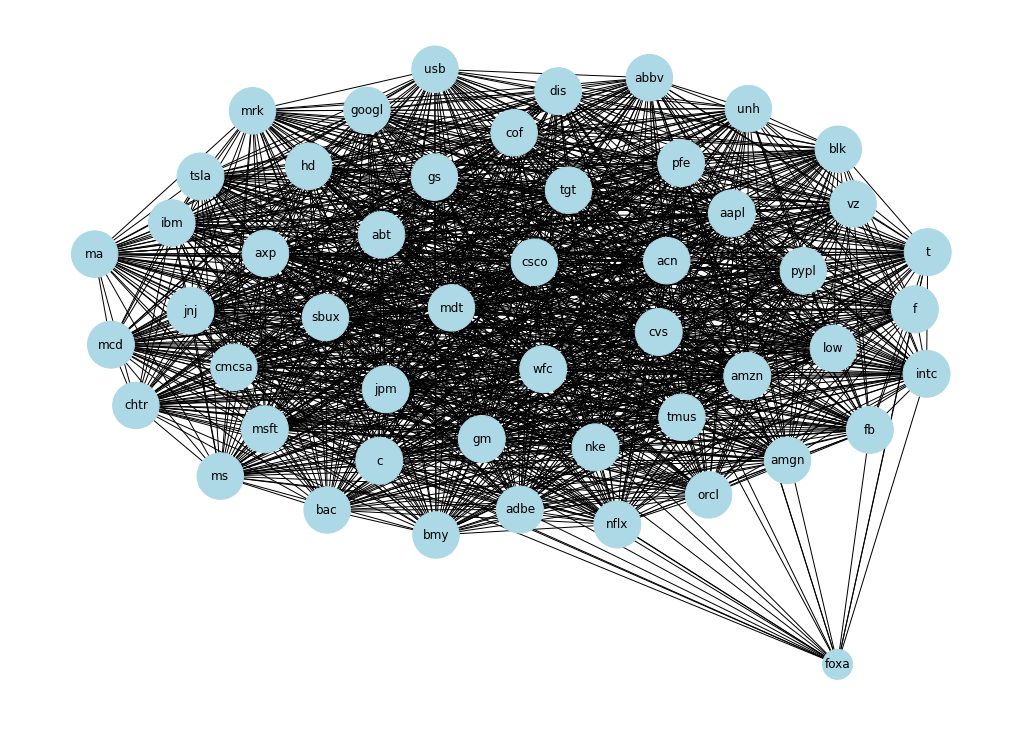

In [694]:
rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(graph, scale=20, k=3/np.sqrt(graph.order()))
d = dict(graph.degree)
nx.draw(graph, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*45 for k in d])

# 2. Community Detection - Eigenvector

In [669]:
def get_second_eigenvector(graph, seed):
    """
    1. Create the Laplacian matrix.
    2. Obtain its eigenvector matrix using the eigh function.
    3. Return the second column eigenvector 
    Returns:
      a 1d numpy array containing the second eigenvector
    >>> np.round(get_second_eigenvector(example_graph()), 2)
    array([ 0.49,  0.3 ,  0.49, -0.21, -0.36, -0.36, -0.36])
    """
    return nx.fiedler_vector(graph, seed=seed) * (-1)
#     adjacency = nx.adjacency_matrix(graph, sorted(graph.nodes()))
#     degrees = dict(graph.degree()).items()
#     degrees = sorted(degrees, key=lambda x: x[0])
#     degrees = [d[1] for d in degrees] 
#     degree = np.diag(degrees)
#     laplacian = degree - adjacency
#     eig_vals, eig_vectors = eigh(laplacian)
#     eig_vectors = np.round(eig_vectors, 2)
#     return eig_vectors[:,1]
#     adjacency_matrix = nx.adjacency_matrix(graph, sorted(graph.nodes()))

#     degrees = dict(graph.degree()).items()
#     degrees = sorted(degrees, key=lambda x: x[0]) 
#     degrees = [d[1] for d in degrees] 
#     degree_matrix = np.diag(degrees)

#     laplacian_matrix = degree_matrix - adjacency_matrix

#     eig_vals, eig_vectors = eigh(laplacian_matrix)
#     eig_vectors = np.round(eig_vectors, 2)
    
#     return eig_vectors[:,1]

def partition_by_eigenvector(graph, seed):
    """
    Using the get_second_eigenvector function above, partition the graph into
    two components using a splitting threshold of 0. That is, nodes
    whose corresponding value in the second eigenvector is >= 0 are in one cluster,
    and the rest are in the other cluster.
    Returns:
      A list of two networkx Graph objects, one per partition. 
      Sort these in ascending order of partition size.
    >>> graph = example_graph()
    >>> result = partition_by_eigenvector(graph)
    >>> sorted(result[0].nodes())
    ['A', 'B', 'C']
    >>> sorted(result[1].nodes())
    ['D', 'E', 'F', 'G']
    >>> round(norm_cut(result[0].nodes(), result[1].nodes(), graph),  2)
    0.42
    """
    node_larger = []
    node_lower = []
    nodes = list(graph.nodes())
    eigenvector_2 = list(get_second_eigenvector(graph, seed))
    for node, eigenvector in dict(zip(nodes, eigenvector_2)).items():
        if eigenvector >= 0:
            node_larger.append(node)
        else:
            node_lower.append(node)

    subgraph_larger = graph.subgraph(node_larger)
    subgraph_lower = graph.subgraph(node_lower)

    return [subgraph_larger, subgraph_lower]

## 2.1.1 First Time Partition

In [670]:
seed = 4 #4
result_1 = partition_by_eigenvector(graph, seed)

In [671]:
com_1 = sorted(result_1[0].nodes())
print(len(com_1))
com_1

40


['aapl',
 'abbv',
 'abt',
 'acn',
 'amgn',
 'axp',
 'bac',
 'blk',
 'bmy',
 'chtr',
 'cmcsa',
 'cof',
 'csco',
 'f',
 'gm',
 'googl',
 'gs',
 'hd',
 'ibm',
 'jnj',
 'jpm',
 'low',
 'ma',
 'mcd',
 'mdt',
 'mrk',
 'ms',
 'msft',
 'nke',
 'orcl',
 'pfe',
 'pypl',
 'sbux',
 't',
 'tgt',
 'tmus',
 'tsla',
 'unh',
 'usb',
 'vz']

In [672]:
# Consumer Discretionary
com_2 = sorted(result_1[1].nodes())
print(len(com_2))
com_2

10


['adbe', 'amzn', 'c', 'cvs', 'dis', 'fb', 'foxa', 'intc', 'nflx', 'wfc']

In [583]:
info_com_2 = []
for ticker in com_2:
    T = ticker.upper()
    info_com_2.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                       df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_2)

[('Communication Services', 'AT&T'),
 ('Communication Services', 'Fox'),
 ('Communication Services', 'Meta'),
 ('Consumer Discretionary', 'Amazon'),
 ('Consumer Discretionary', 'Ford'),
 ('Consumer Discretionary', "McDonald's"),
 ('Consumer Discretionary', 'Tesla'),
 ('Health Care', 'Johnson & Johnson'),
 ('Information Technology', 'Intel'),
 ('Information Technology', 'Microsoft')]

## 2.1.2 Second Time Partition - 'com_1' 

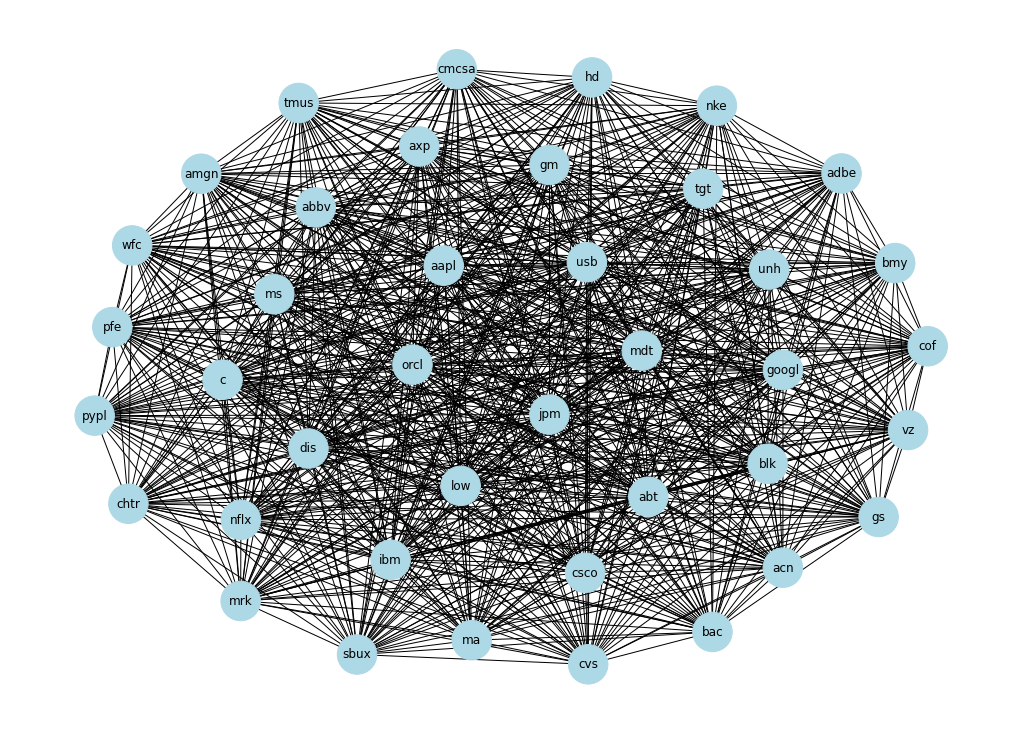

In [584]:
graph_com_1 = graph.subgraph(com_1)
# nx.draw(graph_com_1, with_labels=True)
pos = nx.spring_layout(graph_com_1, scale=20, k=3/np.sqrt(graph_com_1.order()))
d = dict(graph_com_1.degree)
nx.draw(graph_com_1, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*40 for k in d])

In [585]:
seed = 2
result_2 = partition_by_eigenvector(graph_com_1, seed)

In [586]:
com_1_1 = sorted(result_2[0].nodes())
print(len(com_1_1))
com_1_1

20


['aapl',
 'abbv',
 'abt',
 'amgn',
 'blk',
 'chtr',
 'cof',
 'csco',
 'gm',
 'hd',
 'low',
 'ma',
 'mrk',
 'ms',
 'orcl',
 'sbux',
 'tmus',
 'unh',
 'usb',
 'wfc']

In [587]:
info_com_1_1 = []
for ticker in com_1_1:
    T = ticker.upper()
    info_com_1_1.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                         df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_1)

[('Communication Services', 'Charter Communications'),
 ('Communication Services', 'T-Mobile'),
 ('Consumer Discretionary', 'GM'),
 ('Consumer Discretionary', 'Home Depot'),
 ('Consumer Discretionary', "Lowe's"),
 ('Consumer Discretionary', 'Starbucks'),
 ('Financials', 'BlackRock'),
 ('Financials', 'Capital One'),
 ('Financials', 'Morgan Stanley'),
 ('Financials', 'U.S. Bank'),
 ('Financials', 'Wells Fargo'),
 ('Health Care', 'AbbVie'),
 ('Health Care', 'Abbott'),
 ('Health Care', 'Amgen'),
 ('Health Care', 'Merck'),
 ('Health Care', 'UnitedHealth'),
 ('Information Technology', 'Apple'),
 ('Information Technology', 'Cisco'),
 ('Information Technology', 'Mastercard'),
 ('Information Technology', 'Oracle')]

In [588]:
com_1_2 = sorted(result_2[1].nodes())
print(len(com_1_2))
com_1_2

20


['acn',
 'adbe',
 'axp',
 'bac',
 'bmy',
 'c',
 'cmcsa',
 'cvs',
 'dis',
 'googl',
 'gs',
 'ibm',
 'jpm',
 'mdt',
 'nflx',
 'nke',
 'pfe',
 'pypl',
 'tgt',
 'vz']

In [589]:
info_com_1_2 = []
for ticker in com_1_2:
    T = ticker.upper()
    info_com_1_2.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                         df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_2)

[('Communication Services', 'Alphabet (Class A)'),
 ('Communication Services', 'Comcast'),
 ('Communication Services', 'Disney'),
 ('Communication Services', 'Netflix'),
 ('Communication Services', 'Verizon'),
 ('Consumer Discretionary', 'Nike'),
 ('Consumer Discretionary', 'Target'),
 ('Financials', 'American Express'),
 ('Financials', 'Bank of America'),
 ('Financials', 'Citigroup'),
 ('Financials', 'Goldman Sachs'),
 ('Financials', 'JPMorgan Chase'),
 ('Health Care', 'Bristol Myers Squibb'),
 ('Health Care', 'CVS Health'),
 ('Health Care', 'Medtronic'),
 ('Health Care', 'Pfizer'),
 ('Information Technology', 'Accenture'),
 ('Information Technology', 'Adobe'),
 ('Information Technology', 'IBM'),
 ('Information Technology', 'PayPal')]

## 2.1.3 Third Time Partition- 'com_1_1'

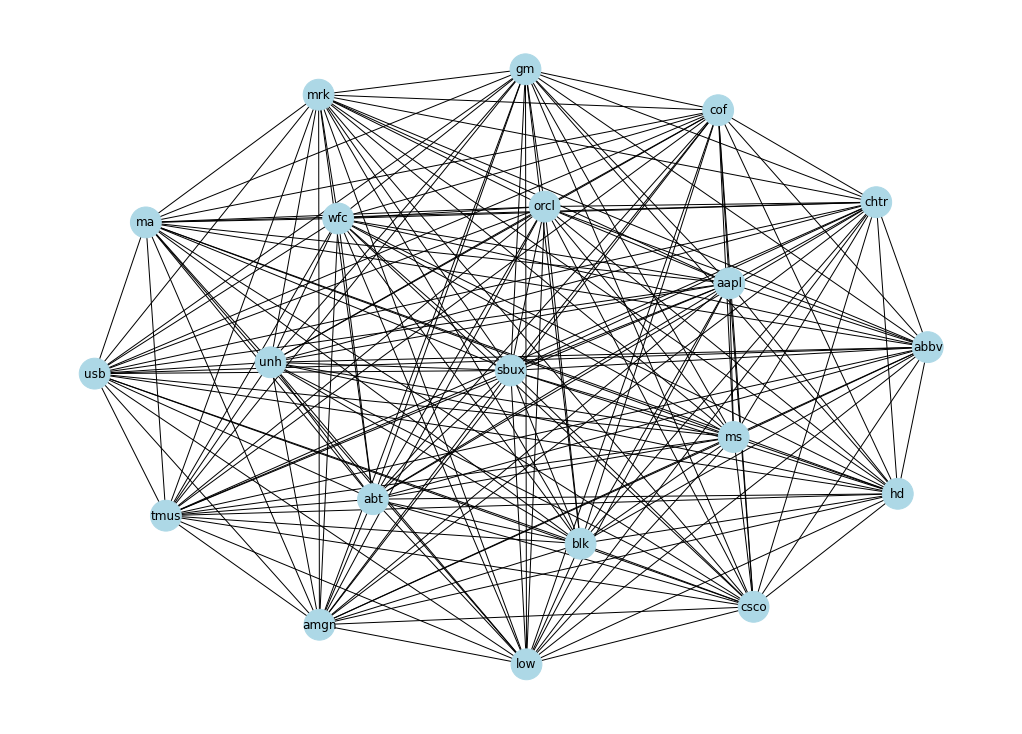

In [590]:
graph_com_1_1 = graph.subgraph(com_1_1)
# nx.draw(graph_com_1_1, with_labels=True)
pos = nx.spring_layout(graph_com_1_1, scale=20, k=3/np.sqrt(graph_com_1_1.order()))
d = dict(graph_com_1_1.degree)
nx.draw(graph_com_1_1, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*50 for k in d])

In [591]:
seed = 3 #3
result_3 = partition_by_eigenvector(graph_com_1_1, seed)

In [592]:
# Health Care
com_1_1_1 = sorted(result_3[0].nodes())
print(len(com_1_1_1))
com_1_1_1

10


['aapl', 'abbv', 'amgn', 'chtr', 'gm', 'mrk', 'orcl', 'sbux', 'unh', 'usb']

In [593]:
info_com_1_1_1 = []
for ticker in com_1_1_1:
    T = ticker.upper()
    info_com_1_1_1.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                           df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_1_1)

[('Communication Services', 'Charter Communications'),
 ('Consumer Discretionary', 'GM'),
 ('Consumer Discretionary', 'Starbucks'),
 ('Financials', 'U.S. Bank'),
 ('Health Care', 'AbbVie'),
 ('Health Care', 'Amgen'),
 ('Health Care', 'Merck'),
 ('Health Care', 'UnitedHealth'),
 ('Information Technology', 'Apple'),
 ('Information Technology', 'Oracle')]

In [594]:
# Financials
com_1_1_2 = sorted(result_3[1].nodes())
print(len(com_1_1_2))
com_1_1_2

10


['abt', 'blk', 'cof', 'csco', 'hd', 'low', 'ma', 'ms', 'tmus', 'wfc']

In [595]:
info_com_1_1_2 = []
for ticker in com_1_1_2:
    T = ticker.upper()
    info_com_1_1_2.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                           df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_1_2)

[('Communication Services', 'T-Mobile'),
 ('Consumer Discretionary', 'Home Depot'),
 ('Consumer Discretionary', "Lowe's"),
 ('Financials', 'BlackRock'),
 ('Financials', 'Capital One'),
 ('Financials', 'Morgan Stanley'),
 ('Financials', 'Wells Fargo'),
 ('Health Care', 'Abbott'),
 ('Information Technology', 'Cisco'),
 ('Information Technology', 'Mastercard')]

## 2.1.4 Fourth Time Partition - 'com_1_2'

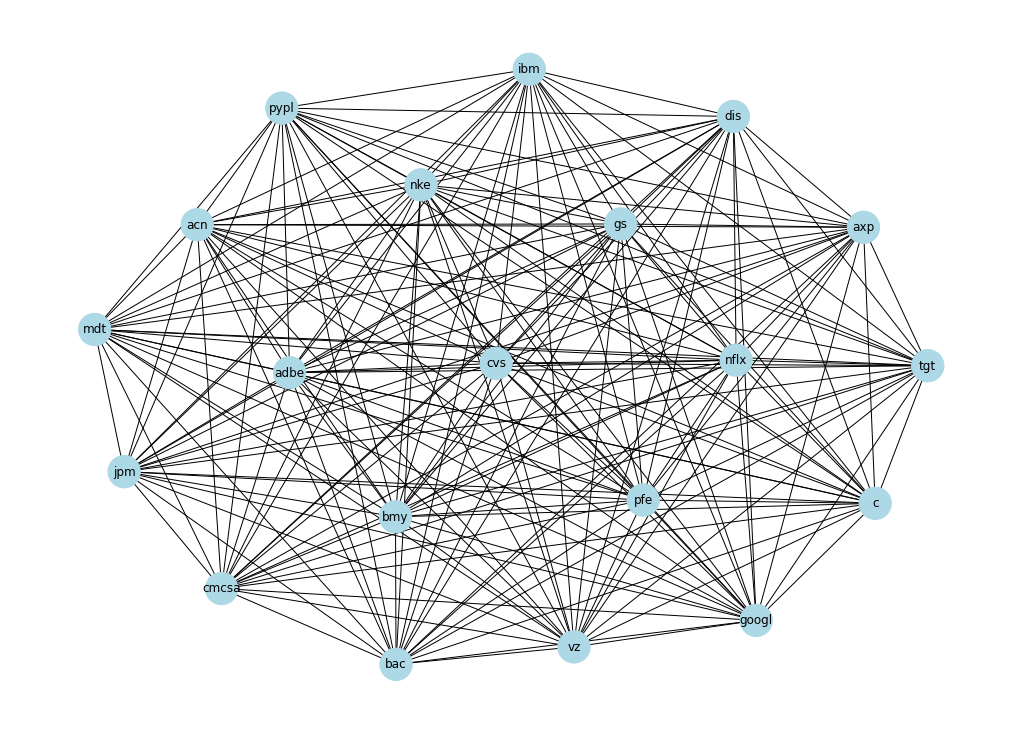

In [596]:
graph_com_1_2 = graph.subgraph(com_1_2)
# nx.draw(graph_com_1_2, with_labels=True)
pos = nx.spring_layout(graph_com_1_2, scale=20, k=3/np.sqrt(graph_com_1_2.order()))
d = dict(graph_com_1_2.degree)
nx.draw(graph_com_1_2, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*55 for k in d])

In [597]:
seed = 2
result_4 = partition_by_eigenvector(graph_com_1_2, seed)

In [598]:
# Information Technology
com_1_2_1 = sorted(result_4[0].nodes())
print(len(com_1_2_1))
com_1_2_1

10


['acn', 'adbe', 'bac', 'bmy', 'c', 'jpm', 'mdt', 'nke', 'pfe', 'pypl']

In [599]:
info_com_1_2_1 = []
for ticker in com_1_2_1:
    T = ticker.upper()
    info_com_1_2_1.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                           df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_2_1)

[('Consumer Discretionary', 'Nike'),
 ('Financials', 'Bank of America'),
 ('Financials', 'Citigroup'),
 ('Financials', 'JPMorgan Chase'),
 ('Health Care', 'Bristol Myers Squibb'),
 ('Health Care', 'Medtronic'),
 ('Health Care', 'Pfizer'),
 ('Information Technology', 'Accenture'),
 ('Information Technology', 'Adobe'),
 ('Information Technology', 'PayPal')]

In [600]:
# Communication Services
com_1_2_2 = sorted(result_4[1].nodes())
print(len(com_1_2_2))
com_1_2_2

10


['axp', 'cmcsa', 'cvs', 'dis', 'googl', 'gs', 'ibm', 'nflx', 'tgt', 'vz']

In [448]:
info_com_1_2_2 = []
for ticker in com_1_2_2:
    T = ticker.upper()
    info_com_1_2_2.append((df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_yahoo'].iloc[0],
                           df_stock_info.loc[df_stock_info['ticker'] == T, 'stock'].iloc[0]))
sorted(info_com_1_2_2)

[('Communication Services', 'Alphabet (Class A)'),
 ('Communication Services', 'Comcast'),
 ('Communication Services', 'Disney'),
 ('Communication Services', 'Netflix'),
 ('Communication Services', 'Verizon'),
 ('Consumer Discretionary', 'Target'),
 ('Financials', 'American Express'),
 ('Financials', 'Goldman Sachs'),
 ('Health Care', 'CVS Health'),
 ('Information Technology', 'IBM')]

## New sector classfication for stocks after community detection
- Information Technology: com_1_2_1 = ['acn', 'adbe', 'bac', 'bmy', 'c', 'jpm', 'mdt', 'nke', 'pfe', 'pypl']
- Consumer Discretionary: com_2 = ['amzn', 'f', 'fb', 'foxa', 'intc', 'jnj', 'mcd', 'msft', 't', 'tsla']
- Health Care: com_1_1_1 = ['aapl', 'abbv', 'amgn', 'chtr', 'gm', 'mrk', 'orcl', 'sbux', 'unh', 'usb']
- Communication Services: com_1_2_2 = ['axp', 'cmcsa', 'cvs', 'dis', 'googl', 'gs', 'ibm', 'nflx', 'tgt', 'vz']
- Financials: com_1_1_2 = ['abt', 'blk', 'cof', 'csco', 'hd', 'low', 'ma', 'ms', 'tmus', 'wfc']

In [478]:
# Information Technology
com_1_2_1 #=['acn', 'chtr', 'cmcsa', 'cof', 'csco', 'gs', 'orcl', 'tmus', 'tsla', 'vz']

['acn', 'adbe', 'bac', 'bmy', 'c', 'jpm', 'mdt', 'nke', 'pfe', 'pypl']

In [479]:
sorted(info_com_1_2_1)

[('Consumer Discretionary', 'Nike'),
 ('Financials', 'Bank of America'),
 ('Financials', 'Citigroup'),
 ('Financials', 'JPMorgan Chase'),
 ('Health Care', 'Bristol Myers Squibb'),
 ('Health Care', 'Medtronic'),
 ('Health Care', 'Pfizer'),
 ('Information Technology', 'Accenture'),
 ('Information Technology', 'Adobe'),
 ('Information Technology', 'PayPal')]

In [480]:
for ticker in com_1_2_1:
    T = ticker.upper()
    df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_community'] = 'Information Technology'
df_stock_info

ticker                   stock            sector_yahoo  \
1    AAPL                   Apple  Information Technology   
2     ACN               Accenture  Information Technology   
3    ADBE                   Adobe  Information Technology   
4    CSCO                   Cisco  Information Technology   
5     IBM                     IBM  Information Technology   
6    INTC                   Intel  Information Technology   
7      MA              Mastercard  Information Technology   
8    MSFT               Microsoft  Information Technology   
9    ORCL                  Oracle  Information Technology   
10   PYPL                  PayPal  Information Technology   
11   ABBV                  AbbVie             Health Care   
12    ABT                  Abbott             Health Care   
13   AMGN                   Amgen             Health Care   
14    BMY    Bristol Myers Squibb             Health Care   
15    CVS              CVS Health             Health Care   
16    JNJ       Johnson & Johnson             Health Care   
17    MDT               Medtronic             Health Care   
18    MRK                   Merck             Health Care   
19    PFE                  Pfizer             Health Care   
20    UNH            UnitedHealth             Health Care   
21    AXP        American Express              Financials   
22    BAC         Bank of America              Financials   
23    BLK               BlackRock              Financials   
24      C               Citigroup              Financials   
25    COF             Capital One              Financials   
26     GS           Goldman Sachs              Financials   
27    JPM          JPMorgan Chase              Financials   
28     MS          Morgan Stanley              Financials   
29    USB               U.S. Bank              Financials   
30    WFC             Wells Fargo              Financials   
31   AMZN                  Amazon  Consumer Discretionary   
32      F                    Ford  Consumer Discretionary   
33     GM                      GM  Consumer Discretionary   
34     HD              Home Depot  Consumer Discretionary   
35    LOW                  Lowe's  Consumer Discretionary   
36    MCD              McDonald's  Consumer Discretionary   
37    NKE                    Nike  Consumer Discretionary   
38   SBUX               Starbucks  Consumer Discretionary   
39    TGT                  Target  Consumer Discretionary   
40   TSLA                   Tesla  Consumer Discretionary   
41   CHTR  Charter Communications  Communication Services   
42  CMCSA                 Comcast  Communication Services   
43    DIS                  Disney  Communication Services   
44     FB                    Meta  Communication Services   
45   FOXA                     Fox  Communication Services   
46  GOOGL      Alphabet (Class A)  Communication Services   
47   NFLX                 Netflix  Communication Services   
48      T                    AT&T  Communication Services   
49   TMUS                T-Mobile  Communication Services   
50     VZ                 Verizon  Communication Services   

          sector_community  
1              Health Care  
2   Information Technology  
3   Information Technology  
4               Financials  
5   Communication Services  
6   Consumer Discretionary  
7               Financials  
8   Consumer Discretionary  
9              Health Care  
10  Information Technology  
11             Health Care  
12              Financials  
13             Health Care  
14  Information Technology  
15  Communication Services  
16  Consumer Discretionary  
17  Information Technology  
18             Health Care  
19  Information Technology  
20             Health Care  
21  Communication Services  
22  Information Technology  
23              Financials  
24  Information Technology  
25              Financials  
26  Communication Services  
27  Information Technology  
28              Financials  
29             Health Care  
30              Finan

In [460]:
# Consumer Discretionary
com_2 #=['dis', 'fb', 'foxa', 'gm', 'intc', 'jnj', 'mcd', 'msft', 'nflx', 'nke']

['amzn', 'f', 'fb', 'foxa', 'intc', 'jnj', 'mcd', 'msft', 't', 'tsla']

In [461]:
sorted(info_com_2)

[('Communication Services', 'AT&T'),
 ('Communication Services', 'Fox'),
 ('Communication Services', 'Meta'),
 ('Consumer Discretionary', 'Amazon'),
 ('Consumer Discretionary', 'Ford'),
 ('Consumer Discretionary', "McDonald's"),
 ('Consumer Discretionary', 'Tesla'),
 ('Health Care', 'Johnson & Johnson'),
 ('Information Technology', 'Intel'),
 ('Information Technology', 'Microsoft')]

In [462]:
for ticker in com_2:
    T = ticker.upper()
    df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_community'] = 'Consumer Discretionary'
df_stock_info

ticker                   stock            sector_yahoo  \
1    AAPL                   Apple  Information Technology   
2     ACN               Accenture  Information Technology   
3    ADBE                   Adobe  Information Technology   
4    CSCO                   Cisco  Information Technology   
5     IBM                     IBM  Information Technology   
6    INTC                   Intel  Information Technology   
7      MA              Mastercard  Information Technology   
8    MSFT               Microsoft  Information Technology   
9    ORCL                  Oracle  Information Technology   
10   PYPL                  PayPal  Information Technology   
11   ABBV                  AbbVie             Health Care   
12    ABT                  Abbott             Health Care   
13   AMGN                   Amgen             Health Care   
14    BMY    Bristol Myers Squibb             Health Care   
15    CVS              CVS Health             Health Care   
16    JNJ       Johnson & Johnson             Health Care   
17    MDT               Medtronic             Health Care   
18    MRK                   Merck             Health Care   
19    PFE                  Pfizer             Health Care   
20    UNH            UnitedHealth             Health Care   
21    AXP        American Express              Financials   
22    BAC         Bank of America              Financials   
23    BLK               BlackRock              Financials   
24      C               Citigroup              Financials   
25    COF             Capital One              Financials   
26     GS           Goldman Sachs              Financials   
27    JPM          JPMorgan Chase              Financials   
28     MS          Morgan Stanley              Financials   
29    USB               U.S. Bank              Financials   
30    WFC             Wells Fargo              Financials   
31   AMZN                  Amazon  Consumer Discretionary   
32      F                    Ford  Consumer Discretionary   
33     GM                      GM  Consumer Discretionary   
34     HD              Home Depot  Consumer Discretionary   
35    LOW                  Lowe's  Consumer Discretionary   
36    MCD              McDonald's  Consumer Discretionary   
37    NKE                    Nike  Consumer Discretionary   
38   SBUX               Starbucks  Consumer Discretionary   
39    TGT                  Target  Consumer Discretionary   
40   TSLA                   Tesla  Consumer Discretionary   
41   CHTR  Charter Communications  Communication Services   
42  CMCSA                 Comcast  Communication Services   
43    DIS                  Disney  Communication Services   
44     FB                    Meta  Communication Services   
45   FOXA                     Fox  Communication Services   
46  GOOGL      Alphabet (Class A)  Communication Services   
47   NFLX                 Netflix  Communication Services   
48      T                    AT&T  Communication Services   
49   TMUS                T-Mobile  Communication Services   
50     VZ                 Verizon  Communication Services   

          sector_community  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
5                      NaN  
6   Consumer Discretionary  
7                      NaN  
8   Consumer Discretionary  
9                      NaN  
10                     NaN  
11                     NaN  
12                     NaN  
13                     NaN  
14                     NaN  
15                     NaN  
16  Consumer Discretionary  
17                     NaN  
18                     NaN  
19                     NaN  
20                     NaN  
21                     NaN  
22                     NaN  
23                     NaN  
24                     NaN  
25                     NaN  
26                     NaN  
27                     NaN  
28                     NaN  
29                     NaN  
30                   

In [465]:
# Health Care
com_1_1_1 #=['aapl', 'abbv', 'bac', 'c', 'jpm', 'low', 'mdt', 'ms', 't', 'wfc']

['aapl', 'abbv', 'amgn', 'chtr', 'gm', 'mrk', 'orcl', 'sbux', 'unh', 'usb']

In [466]:
sorted(info_com_1_1_1)

[('Communication Services', 'Charter Communications'),
 ('Consumer Discretionary', 'GM'),
 ('Consumer Discretionary', 'Starbucks'),
 ('Financials', 'U.S. Bank'),
 ('Health Care', 'AbbVie'),
 ('Health Care', 'Amgen'),
 ('Health Care', 'Merck'),
 ('Health Care', 'UnitedHealth'),
 ('Information Technology', 'Apple'),
 ('Information Technology', 'Oracle')]

In [467]:
for ticker in com_1_1_1:
    T = ticker.upper()
    df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_community'] = 'Health Care'
df_stock_info

ticker                   stock            sector_yahoo  \
1    AAPL                   Apple  Information Technology   
2     ACN               Accenture  Information Technology   
3    ADBE                   Adobe  Information Technology   
4    CSCO                   Cisco  Information Technology   
5     IBM                     IBM  Information Technology   
6    INTC                   Intel  Information Technology   
7      MA              Mastercard  Information Technology   
8    MSFT               Microsoft  Information Technology   
9    ORCL                  Oracle  Information Technology   
10   PYPL                  PayPal  Information Technology   
11   ABBV                  AbbVie             Health Care   
12    ABT                  Abbott             Health Care   
13   AMGN                   Amgen             Health Care   
14    BMY    Bristol Myers Squibb             Health Care   
15    CVS              CVS Health             Health Care   
16    JNJ       Johnson & Johnson             Health Care   
17    MDT               Medtronic             Health Care   
18    MRK                   Merck             Health Care   
19    PFE                  Pfizer             Health Care   
20    UNH            UnitedHealth             Health Care   
21    AXP        American Express              Financials   
22    BAC         Bank of America              Financials   
23    BLK               BlackRock              Financials   
24      C               Citigroup              Financials   
25    COF             Capital One              Financials   
26     GS           Goldman Sachs              Financials   
27    JPM          JPMorgan Chase              Financials   
28     MS          Morgan Stanley              Financials   
29    USB               U.S. Bank              Financials   
30    WFC             Wells Fargo              Financials   
31   AMZN                  Amazon  Consumer Discretionary   
32      F                    Ford  Consumer Discretionary   
33     GM                      GM  Consumer Discretionary   
34     HD              Home Depot  Consumer Discretionary   
35    LOW                  Lowe's  Consumer Discretionary   
36    MCD              McDonald's  Consumer Discretionary   
37    NKE                    Nike  Consumer Discretionary   
38   SBUX               Starbucks  Consumer Discretionary   
39    TGT                  Target  Consumer Discretionary   
40   TSLA                   Tesla  Consumer Discretionary   
41   CHTR  Charter Communications  Communication Services   
42  CMCSA                 Comcast  Communication Services   
43    DIS                  Disney  Communication Services   
44     FB                    Meta  Communication Services   
45   FOXA                     Fox  Communication Services   
46  GOOGL      Alphabet (Class A)  Communication Services   
47   NFLX                 Netflix  Communication Services   
48      T                    AT&T  Communication Services   
49   TMUS                T-Mobile  Communication Services   
50     VZ                 Verizon  Communication Services   

          sector_community  
1              Health Care  
2                      NaN  
3                      NaN  
4                      NaN  
5                      NaN  
6   Consumer Discretionary  
7                      NaN  
8   Consumer Discretionary  
9              Health Care  
10                     NaN  
11             Health Care  
12                     NaN  
13             Health Care  
14                     NaN  
15                     NaN  
16  Consumer Discretionary  
17                     NaN  
18             Health Care  
19                     NaN  
20             Health Care  
21                     NaN  
22                     NaN  
23                     NaN  
24                     NaN  
25                     NaN  
26                     NaN  
27                     NaN  
28                     NaN  
29             Health Care  
30                   

In [470]:
# Communication Services
com_1_2_2 #=['amgn', 'axp', 'blk', 'bmy', 'cvs', 'googl', 'hd', 'mrk', 'sbux', 'unh']

['axp', 'cmcsa', 'cvs', 'dis', 'googl', 'gs', 'ibm', 'nflx', 'tgt', 'vz']

In [471]:
sorted(info_com_1_2_2)

[('Communication Services', 'Alphabet (Class A)'),
 ('Communication Services', 'Comcast'),
 ('Communication Services', 'Disney'),
 ('Communication Services', 'Netflix'),
 ('Communication Services', 'Verizon'),
 ('Consumer Discretionary', 'Target'),
 ('Financials', 'American Express'),
 ('Financials', 'Goldman Sachs'),
 ('Health Care', 'CVS Health'),
 ('Information Technology', 'IBM')]

In [472]:
for ticker in com_1_2_2:
    T = ticker.upper()
    df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_community'] = 'Communication Services'
df_stock_info

ticker                   stock            sector_yahoo  \
1    AAPL                   Apple  Information Technology   
2     ACN               Accenture  Information Technology   
3    ADBE                   Adobe  Information Technology   
4    CSCO                   Cisco  Information Technology   
5     IBM                     IBM  Information Technology   
6    INTC                   Intel  Information Technology   
7      MA              Mastercard  Information Technology   
8    MSFT               Microsoft  Information Technology   
9    ORCL                  Oracle  Information Technology   
10   PYPL                  PayPal  Information Technology   
11   ABBV                  AbbVie             Health Care   
12    ABT                  Abbott             Health Care   
13   AMGN                   Amgen             Health Care   
14    BMY    Bristol Myers Squibb             Health Care   
15    CVS              CVS Health             Health Care   
16    JNJ       Johnson & Johnson             Health Care   
17    MDT               Medtronic             Health Care   
18    MRK                   Merck             Health Care   
19    PFE                  Pfizer             Health Care   
20    UNH            UnitedHealth             Health Care   
21    AXP        American Express              Financials   
22    BAC         Bank of America              Financials   
23    BLK               BlackRock              Financials   
24      C               Citigroup              Financials   
25    COF             Capital One              Financials   
26     GS           Goldman Sachs              Financials   
27    JPM          JPMorgan Chase              Financials   
28     MS          Morgan Stanley              Financials   
29    USB               U.S. Bank              Financials   
30    WFC             Wells Fargo              Financials   
31   AMZN                  Amazon  Consumer Discretionary   
32      F                    Ford  Consumer Discretionary   
33     GM                      GM  Consumer Discretionary   
34     HD              Home Depot  Consumer Discretionary   
35    LOW                  Lowe's  Consumer Discretionary   
36    MCD              McDonald's  Consumer Discretionary   
37    NKE                    Nike  Consumer Discretionary   
38   SBUX               Starbucks  Consumer Discretionary   
39    TGT                  Target  Consumer Discretionary   
40   TSLA                   Tesla  Consumer Discretionary   
41   CHTR  Charter Communications  Communication Services   
42  CMCSA                 Comcast  Communication Services   
43    DIS                  Disney  Communication Services   
44     FB                    Meta  Communication Services   
45   FOXA                     Fox  Communication Services   
46  GOOGL      Alphabet (Class A)  Communication Services   
47   NFLX                 Netflix  Communication Services   
48      T                    AT&T  Communication Services   
49   TMUS                T-Mobile  Communication Services   
50     VZ                 Verizon  Communication Services   

          sector_community  
1              Health Care  
2                      NaN  
3                      NaN  
4                      NaN  
5   Communication Services  
6   Consumer Discretionary  
7                      NaN  
8   Consumer Discretionary  
9              Health Care  
10                     NaN  
11             Health Care  
12                     NaN  
13             Health Care  
14                     NaN  
15  Communication Services  
16  Consumer Discretionary  
17                     NaN  
18             Health Care  
19                     NaN  
20             Health Care  
21  Communication Services  
22                     NaN  
23                     NaN  
24                     NaN  
25                     NaN  
26  Communication Services  
27                     NaN  
28                     NaN  
29             Health Care  
30                   

In [475]:
# Financials
com_1_1_2 #=['abt', 'adbe', 'amzn', 'f', 'ibm', 'ma', 'pfe', 'pypl', 'tgt', 'usb']

['abt', 'blk', 'cof', 'csco', 'hd', 'low', 'ma', 'ms', 'tmus', 'wfc']

In [476]:
sorted(info_com_1_1_2)

[('Communication Services', 'T-Mobile'),
 ('Consumer Discretionary', 'Home Depot'),
 ('Consumer Discretionary', "Lowe's"),
 ('Financials', 'BlackRock'),
 ('Financials', 'Capital One'),
 ('Financials', 'Morgan Stanley'),
 ('Financials', 'Wells Fargo'),
 ('Health Care', 'Abbott'),
 ('Information Technology', 'Cisco'),
 ('Information Technology', 'Mastercard')]

In [481]:
for ticker in com_1_1_2:
    T = ticker.upper()
    df_stock_info.loc[df_stock_info['ticker'] == T, 'sector_community'] = 'Financials'
df_stock_info

ticker                   stock            sector_yahoo  \
1    AAPL                   Apple  Information Technology   
2     ACN               Accenture  Information Technology   
3    ADBE                   Adobe  Information Technology   
4    CSCO                   Cisco  Information Technology   
5     IBM                     IBM  Information Technology   
6    INTC                   Intel  Information Technology   
7      MA              Mastercard  Information Technology   
8    MSFT               Microsoft  Information Technology   
9    ORCL                  Oracle  Information Technology   
10   PYPL                  PayPal  Information Technology   
11   ABBV                  AbbVie             Health Care   
12    ABT                  Abbott             Health Care   
13   AMGN                   Amgen             Health Care   
14    BMY    Bristol Myers Squibb             Health Care   
15    CVS              CVS Health             Health Care   
16    JNJ       Johnson & Johnson             Health Care   
17    MDT               Medtronic             Health Care   
18    MRK                   Merck             Health Care   
19    PFE                  Pfizer             Health Care   
20    UNH            UnitedHealth             Health Care   
21    AXP        American Express              Financials   
22    BAC         Bank of America              Financials   
23    BLK               BlackRock              Financials   
24      C               Citigroup              Financials   
25    COF             Capital One              Financials   
26     GS           Goldman Sachs              Financials   
27    JPM          JPMorgan Chase              Financials   
28     MS          Morgan Stanley              Financials   
29    USB               U.S. Bank              Financials   
30    WFC             Wells Fargo              Financials   
31   AMZN                  Amazon  Consumer Discretionary   
32      F                    Ford  Consumer Discretionary   
33     GM                      GM  Consumer Discretionary   
34     HD              Home Depot  Consumer Discretionary   
35    LOW                  Lowe's  Consumer Discretionary   
36    MCD              McDonald's  Consumer Discretionary   
37    NKE                    Nike  Consumer Discretionary   
38   SBUX               Starbucks  Consumer Discretionary   
39    TGT                  Target  Consumer Discretionary   
40   TSLA                   Tesla  Consumer Discretionary   
41   CHTR  Charter Communications  Communication Services   
42  CMCSA                 Comcast  Communication Services   
43    DIS                  Disney  Communication Services   
44     FB                    Meta  Communication Services   
45   FOXA                     Fox  Communication Services   
46  GOOGL      Alphabet (Class A)  Communication Services   
47   NFLX                 Netflix  Communication Services   
48      T                    AT&T  Communication Services   
49   TMUS                T-Mobile  Communication Services   
50     VZ                 Verizon  Communication Services   

          sector_community  
1              Health Care  
2   Information Technology  
3   Information Technology  
4               Financials  
5   Communication Services  
6   Consumer Discretionary  
7               Financials  
8   Consumer Discretionary  
9              Health Care  
10  Information Technology  
11             Health Care  
12              Financials  
13             Health Care  
14  Information Technology  
15  Communication Services  
16  Consumer Discretionary  
17  Information Technology  
18             Health Care  
19  Information Technology  
20             Health Care  
21  Communication Services  
22  Information Technology  
23              Financials  
24  Information Technology  
25              Financials  
26  Communication Services  
27  Information Technology  
28              Financials  
29             Health Care  
30              Finan

In [482]:
# create csv
df_stock_info.to_csv('/Users/hanyulun/Dropbox/UChi/Spring2022/MACS 36000/proj/Data/stock_sector_by_comm.csv', 
                     encoding='utf-8', 
                     index=True)

## 2.2 Evaluation for Community Detection
- each sector is fully conntected

### 2.2.1 Communication Services Sector

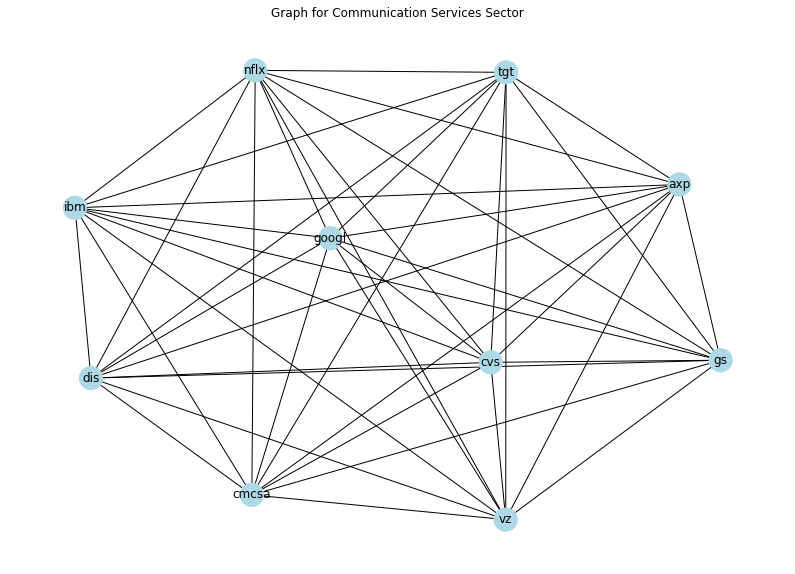

In [718]:
# Communication Services Sector
sector = 'Communication Services Sector'
graph_eva = graph.subgraph(com_1_2_2)
plt.title('Graph for' + ' '+sector)
pos = nx.spring_layout(graph_eva, scale=20, k=3/np.sqrt(graph_eva.order()))
d = dict(graph_eva.degree)
nx.draw(graph_eva, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*60 for k in d])

In [719]:
# Graph Density
def total_edges(N):
    return N * (N - 1) / 2

density_communication = 1. * len(graph_eva.edges()) / total_edges(len(graph_eva.nodes()))
print('Graph Density for'+ ' '+ sector+':'+'%.3f' % 
      (density_communication))

# Average Node Degree
def average_node_degree(G):
    sum_ = 0
    for tup in list(G.degree):
        sum_ += tup[1]
    rv = sum_/len(G.degree)
    return rv

avg_node_deg_communication = average_node_degree(graph_eva)
print('Average Node Degree for'+ ' '+sector+':' +'%.3f' % 
     (avg_node_deg_communication))

# Average Clustering Coefficient
avg_coeff_communication = np.mean(list(nx.clustering(graph_eva).values()))
print("Average Clustering Coefficient for"+" "+sector+":" "%.3f" % avg_coeff_communication)
nx.clustering(graph_eva)

Graph Density for Communication Services Sector:1.000
Average Node Degree for Communication Services Sector:9.000
Average Clustering Coefficient for Communication Services Sector:1.000


{'cmcsa': 1.0,
 'ibm': 1.0,
 'axp': 1.0,
 'gs': 1.0,
 'nflx': 1.0,
 'vz': 1.0,
 'dis': 1.0,
 'tgt': 1.0,
 'googl': 1.0,
 'cvs': 1.0}

### 2.2.2 Consumer Discretionary

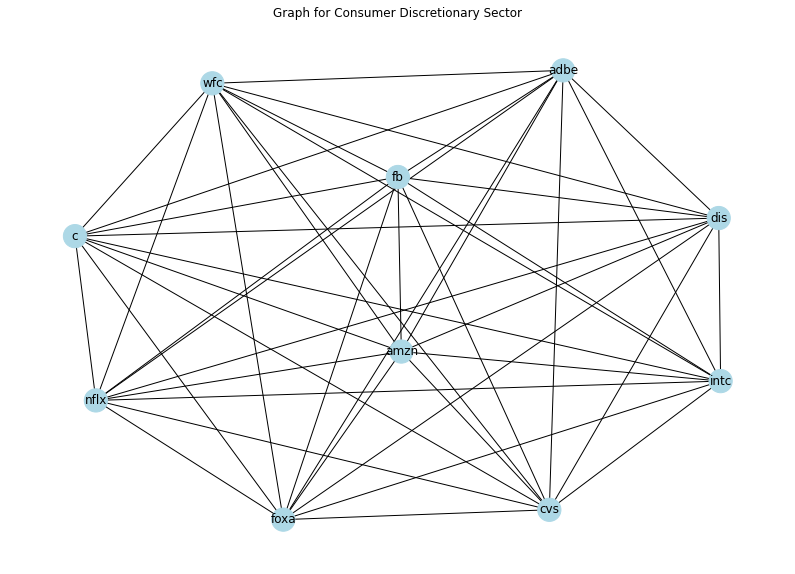

In [715]:
sector = 'Consumer Discretionary Sector'
graph_eva = graph.subgraph(com_2)
plt.title('Graph for' + ' '+sector)
pos = nx.spring_layout(graph_eva, scale=20, k=3/np.sqrt(graph_eva.order()))
d = dict(graph_eva.degree)
nx.draw(graph_eva, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*60 for k in d])

In [716]:
# Graph Density
def total_edges(N):
    return N * (N - 1) / 2

density_consumer = 1. * len(graph_eva.edges()) / total_edges(len(graph_eva.nodes()))
print('Graph Density for'+ ' '+ sector+':'+'%.3f' % 
      (density_consumer))

# Average Node Degree
def average_node_degree(G):
    sum_ = 0
    for tup in list(G.degree):
        sum_ += tup[1]
    rv = sum_/len(G.degree)
    return rv

avg_node_deg_consumer = average_node_degree(graph_eva)
print('Average Node Degree for'+ ' '+sector+':' +'%.3f' % 
     (avg_node_deg_consumer))

# Average Clustering Coefficient
avg_coeff_consumer = np.mean(list(nx.clustering(graph_eva).values()))
print("Average Clustering Coefficient for"+" "+sector+":" "%.3f" % avg_coeff_consumer)
nx.clustering(graph_eva)

Graph Density for Consumer Discretionary Sector:1.000
Average Node Degree for Consumer Discretionary Sector:9.000
Average Clustering Coefficient for Consumer Discretionary Sector:1.000


{'intc': 1.0,
 'adbe': 1.0,
 'foxa': 1.0,
 'wfc': 1.0,
 'c': 1.0,
 'fb': 1.0,
 'nflx': 1.0,
 'dis': 1.0,
 'amzn': 1.0,
 'cvs': 1.0}

### 2.2.3 Financials

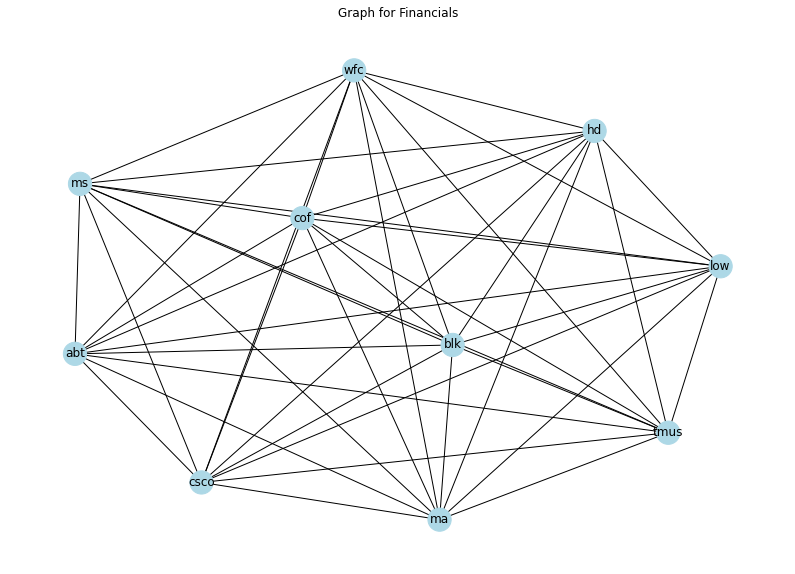

In [713]:
sector = 'Financials'
graph_eva = graph.subgraph(com_1_1_2)
plt.title('Graph for' + ' '+sector)
pos = nx.spring_layout(graph_eva, scale=20, k=3/np.sqrt(graph_eva.order()))
d = dict(graph_eva.degree)
nx.draw(graph_eva, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*60 for k in d])

In [714]:
# Graph Density
def total_edges(N):
    return N * (N - 1) / 2

density_fin = 1. * len(graph_eva.edges()) / total_edges(len(graph_eva.nodes()))
print('Graph Density for'+ ' '+ sector+':'+'%.3f' % 
      (density_fin))

# Average Node Degree
def average_node_degree(G):
    sum_ = 0
    for tup in list(G.degree):
        sum_ += tup[1]
    rv = sum_/len(G.degree)
    return rv

avg_node_deg_fin = average_node_degree(graph_eva)
print('Average Node Degree for'+ ' '+sector+':' +'%.3f' % 
     (avg_node_deg_fin))

# Average Clustering Coefficient
avg_coeff_fin = np.mean(list(nx.clustering(graph_eva).values()))
print("Average Clustering Coefficient for"+" "+sector+":" "%.3f" % avg_coeff_fin)
nx.clustering(graph_eva)

Graph Density for Financials:1.000
Average Node Degree for Financials:9.000
Average Clustering Coefficient for Financials:1.000


{'hd': 1.0,
 'ma': 1.0,
 'wfc': 1.0,
 'csco': 1.0,
 'cof': 1.0,
 'abt': 1.0,
 'low': 1.0,
 'ms': 1.0,
 'blk': 1.0,
 'tmus': 1.0}

### 2.2.4 Health Care

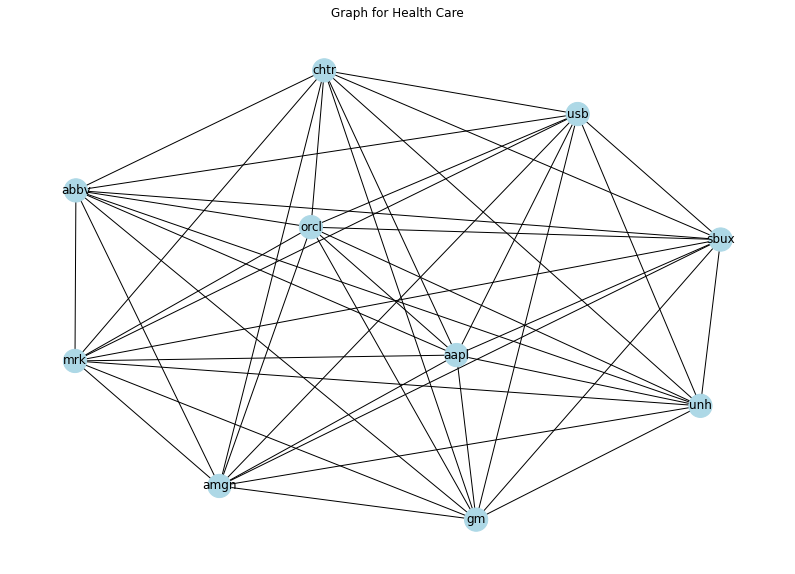

In [710]:
sector = 'Health Care'
graph_eva = graph.subgraph(com_1_1_1)
plt.title('Graph for' + ' '+sector)
pos = nx.spring_layout(graph_eva, scale=20, k=3/np.sqrt(graph_eva.order()))
d = dict(graph_eva.degree)
nx.draw(graph_eva, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*60 for k in d])

In [711]:
# Graph Density
def total_edges(N):
    return N * (N - 1) / 2

density_health = 1. * len(graph_eva.edges()) / total_edges(len(graph_eva.nodes()))
print('Graph Density for'+ ' '+ sector+':'+'%.3f' % 
      (density_health))

# Average Node Degree
def average_node_degree(G):
    sum_ = 0
    for tup in list(G.degree):
        sum_ += tup[1]
    rv = sum_/len(G.degree)
    return rv

avg_node_deg_health = average_node_degree(graph_eva)
print('Average Node Degree for'+ ' '+sector+':' +'%.3f' % 
     (avg_node_deg_health))

# Average Clustering Coefficient
avg_coeff_health = np.mean(list(nx.clustering(graph_eva).values()))
print("Average Clustering Coefficient for"+" "+sector+":" "%.3f" % avg_coeff_health)
nx.clustering(graph_eva)

Graph Density for Health Care:1.000
Average Node Degree for Health Care:9.000
Average Clustering Coefficient for Health Care:1.000


{'gm': 1.0,
 'abbv': 1.0,
 'mrk': 1.0,
 'orcl': 1.0,
 'amgn': 1.0,
 'usb': 1.0,
 'unh': 1.0,
 'chtr': 1.0,
 'aapl': 1.0,
 'sbux': 1.0}

### 2.2.5 Information Technology

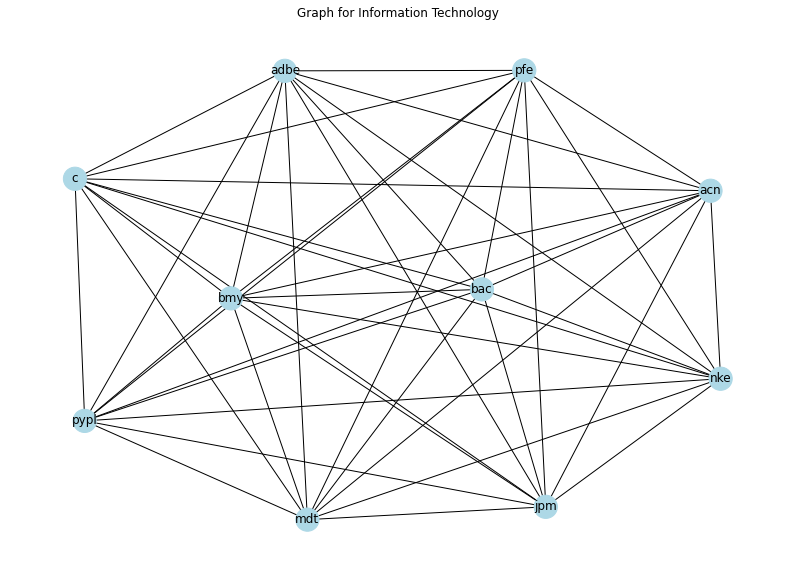

In [706]:
sector = 'Information Technology'
graph_eva = graph.subgraph(com_1_2_1)
plt.title('Graph for' + ' '+sector)
pos = nx.spring_layout(graph_eva, scale=20, k=3/np.sqrt(graph_eva.order()))
d = dict(graph_eva.degree)
nx.draw(graph_eva, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*60 for k in d])

In [708]:
# Graph Density
def total_edges(N):
    return N * (N - 1) / 2

density_tech = 1. * len(graph_eva.edges()) / total_edges(len(graph_eva.nodes()))
print('Graph Density for'+ ' '+ sector+':'+'%.3f' % 
      (density_tech))

# Average Node Degree
def average_node_degree(G):
    sum_ = 0
    for tup in list(G.degree):
        sum_ += tup[1]
    rv = sum_/len(G.degree)
    return rv

avg_node_deg_tech = average_node_degree(graph_eva)
print('Average Node Degree for'+ ' '+sector+':' +'%.3f' % 
     (avg_node_deg_tech))

# Average Clustering Coefficient
avg_coeff_tech = np.mean(list(nx.clustering(graph_eva).values()))
print("Average Clustering Coefficient for"+" "+sector+":" "%.3f" % avg_coeff_tech)
nx.clustering(graph_eva)

Graph Density for Information Technology:1.000
Average Node Degree for Information Technology:9.000
Average Clustering Coefficient for Information Technology:1.000


{'pfe': 1.0,
 'adbe': 1.0,
 'pypl': 1.0,
 'acn': 1.0,
 'bac': 1.0,
 'c': 1.0,
 'jpm': 1.0,
 'bmy': 1.0,
 'mdt': 1.0,
 'nke': 1.0}

## 2.3 Comparison for Evaluation Result of Each Community

In [730]:
data_eva = {'Average Clustering Coefficient': [avg_coeff_communication, 
                                               avg_coeff_consumer, 
                                               avg_coeff_fin, 
                                               avg_coeff_health, 
                                               avg_coeff_tech], 
            'Average Node Degree': [avg_node_deg_communication, 
                                    avg_node_deg_consumer, 
                                    avg_node_deg_fin, 
                                    avg_node_deg_health, 
                                    avg_node_deg_tech],
            'Graph Density': [density_communication, 
                              density_consumer, 
                              density_fin, 
                              density_health, 
                              density_tech]}
df_eva = pd.DataFrame(data_eva, index=['Communication Services', 
                                       'Consumer Discretionary', 
                                       'Financials',
                                       'Health Care',
                                       'Information Technology'])
pd.set_option('display.float_format', '{:.3f}'.format)
df_eva.style.set_table_attributes("style='display:inline'").set_caption("Evaluation Result for Community Detection")


# 3. Sentiment Analysis

In [1185]:
def sentiment_score(ticker):
    
    posts_df = pd.read_csv("Data/sentiment_data/sentiment_" + ticker + ".csv", index_col=0) # change name
    idx_df = pd.read_csv("Data/sector_index_price_data/sp500_financial_index.csv")
    idx_df = idx_df[["Date"]]
    idx_df.columns = ['date']
    polarity = []
    date = idx_df["date"].tolist()
    for i in date:
        daily_polarity = posts_df.loc[posts_df['post_time'].str.contains(i, case = False)]
        avg_polarity = daily_polarity['polarity_hiv4'].mean()
        polarity.append(avg_polarity)
    idx_df['polarity_'+ ticker] = polarity
#         idx_df = idx_df.loc[:, ~idx_df.columns.str.contains('^Unnamed')]
    idx_df.to_csv("Data/sentiment_score_data/sentiment_score_" + ticker + ".csv")
    return idx_df

In [1193]:
communities = [com_1_1_2, com_1_2_2, com_1_1_1, com_1_2_1, com_2]
for comm in communities:
    for ticker in comm:
        sentiment_score(ticker) 

In [1203]:
tickers = ['jpm', 'wfc']
sector = 'financial'
idx_df = pd.read_csv("Data/sector_index_price_data/sp500_" + sector +"_index.csv")
idx_df = idx_df[["Date", "Adj Close**"]]
idx_df.columns = ['date', 'close_price']
for ticker in tickers:
    score_df = pd.read_csv("Data/sentiment_score_data/sentiment_score_" + ticker + ".csv")
    idx_df['polarity_'+ticker] = score_df['polarity_'+ticker].values
idx_df

date  close_price  polarity_jpm  polarity_wfc
0   2022-05-06       576.98      0.087790      0.400000
1   2022-05-05       581.15      0.298092      0.260795
2   2022-05-04       598.60      0.196027      0.453658
3   2022-05-03       581.06      0.012111      0.451389
4   2022-05-02       573.82      0.287913      0.166667
5   2022-04-29       573.70      0.222063      0.362987
6   2022-04-28       593.95      0.165429      0.405405
7   2022-04-27       586.34     -0.001961      0.268817
8   2022-04-26       586.94     -0.009259      0.311823
9   2022-04-25       602.29      0.169823      0.234140
10  2022-04-22       601.30      0.121817      0.451323
11  2022-04-21       619.90      0.152339      0.268817
12  2022-04-20       629.57      0.150070      0.407895
13  2022-04-19       625.28     -0.024732      0.476788
14  2022-04-18       617.14      0.205585      0.316955
15  2022-04-14       613.38      0.205883      0.194521
16  2022-04-13       619.85      0.094472      0.301219
17  2022-04-12       620.35      0.100216      0.148414
18  2022-04-11       627.04      0.147423      0.209552
19  2022-04-08       630.05      0.074257      0.321212
20  2022-04-07       623.78      0.069313      0.154794
21  2022-04-06       624.39      0.139111      0.204928
22  2022-04-05       628.52     -0.117628     -0.050762
23  2022-04-04       633.25      0.026049     -0.005556
24  2022-04-01       636.27      0.068014      0.260846
25  2022-03-31       637.61      0.084788      0.204762
26  2022-03-30       652.76      0.208163      0.102609
27  2022-03-29       657.40      0.213442      0.124542
28  2022-03-28       655.86      0.147143      0.405988
29  2022-03-25       657.82      0.062168      0.039216
30  2022-03-24       649.33      0.008424      0.187302
31  2022-03-23       644.46      0.085955     -0.011640
32  2022-03-22       656.55      0.223540      0.298052
33  2022-03-21       646.21      0.082114      0.259148
34  2022-03-18       647.02      0.087796      0.165789
35  2022-03-17       645.14      0.231852      0.454248
36  2022-03-16       637.31      0.313095      0.180408
37  2022-03-15       619.46      0.251657      0.085281
38  2022-03-14       611.45      0.077241      0.090667
39  2022-03-11       603.92     -0.019816     -0.225555
40  2022-03-10       608.28      0.084392      0.377274
41  2022-03-09       613.18      0.065335      0.279509
42  2022-03-08       591.79      0.208620      0.243298
43  2022-03-07       595.06      0.160000      0.239583
44  2022-03-04       617.65      0.158636      0.438889
45  2022-03-03       629.98      0.048452      0.386939
46  2022-03-02       631.87      0.099843      0.356465
47  2022-03-01       616.13      0.076354      0.301587

# 3. Stock Price Prediction - Random Forest Regression Algorithm 
- based on previous research, Random Forest was the best performing model with larger Twitter datasets
- 48 trading days

In [966]:
def import_dataset(tickers, sector):
    df = pd.read_csv("Data/sector_index_price_data/sp500_" + sector +"_index.csv")
    df = df[["Date", "Adj Close**"]]
    df.columns = ['date', 'close_price']
    for ticker in tickers:
        score_df = pd.read_csv("Data/sentiment_score_data/sentiment_score_" + ticker + ".csv")
        df['polarity_'+ticker] = score_df['polarity_'+ticker].values
    df.set_index("date", inplace=True)
    df.dropna(inplace=True)
    df = df.sort_values(by='date')
    return df

## 3.1. Finanical Sector

### 3.1.1 Community Detection
- com_1_1_2 = ['abt', 'blk', 'cof', 'csco', 'hd', 'low', 'ma', 'ms', 'tmus', 'wfc']

In [999]:
# import dataset of sector index and sentiment score
tickers = com_1_1_2
sector = 'financial'
df_fin_comm = import_dataset(tickers, sector)
df_fin_comm

close_price  polarity_abt  polarity_blk  polarity_cof  \
date                                                                
2022-03-03      629.980        -0.043         0.575         0.737   
2022-03-04      617.650         0.919        -0.012         0.714   
2022-03-07      595.060         0.228         0.243         0.630   
2022-03-08      591.790         1.000        -0.045         0.200   
2022-03-09      613.180         0.650         0.243         0.778   
2022-03-10      608.280         0.200         0.368         0.900   
2022-03-11      603.920         0.182         0.022         0.030   
2022-03-14      611.450         0.109         0.220         0.733   
2022-03-15      619.460         0.296         0.085         0.481   
2022-03-16      637.310         0.270        -0.004         0.444   
2022-03-17      645.140         0.456         0.470         0.483   
2022-03-18      647.020         0.077         0.333         0.819   
2022-03-21      646.210         0.111         0.119         0.155   
2022-03-22      656.550         0.467         0.779         0.683   
2022-03-23      644.460         0.112         0.080         1.000   
2022-03-24      649.330         0.204        -0.008         0.400   
2022-03-25      657.820        -0.043         0.281         1.000   
2022-03-28      655.860         0.564         0.319         0.612   
2022-03-29      657.400         0.203         0.385         0.600   
2022-03-30      652.760         0.408         0.222         0.419   
2022-03-31      637.610         0.500         0.278         0.500   
2022-04-01      636.270         0.335         0.407         0.482   
2022-04-04      633.250         0.597         0.213         0.833   
2022-04-05      628.520         0.175         0.285        -0.500   
2022-04-06      624.390         0.667         0.508         0.352   
2022-04-07      623.780         0.542         0.245         0.210   
2022-04-08      630.050         0.381         0.224         0.917   
2022-04-11      627.040         0.833         0.313         0.650   
2022-04-12      620.350         0.260         0.207         0.720   
2022-04-13      619.850         0.050         0.172         0.354   
2022-04-14      613.380         0.371         0.121         1.000   
2022-04-18      617.140         0.287         0.014         0.000   
2022-04-19      625.280         0.337         0.169         0.297   
2022-04-20      629.570         0.211         0.232         0.889   
2022-04-21      619.900         0.375         0.176        -1.000   
2022-04-22      601.300         0.495         0.225         0.500   
2022-04-25      602.290         0.427         0.348         0.800   
2022-04-26      586.940         0.460         0.316         0.352   
2022-04-27      586.340         0.595         0.437         0.440   
2022-04-28      593.950         0.578         0.583         0.704   
2022-04-29      573.700         0.130         0.255         0.611   
2022-05-02      573.820         0.508         0.380         0.700   
2022-05-03      581.060         0.403         0.722         0.645   
2022-05-04      598.600         0.369         0.667         0.571   
2022-05-05      581.150         0.468         0.442         0.500   
2022-05-06      576.980         0.733         0.286         0.450   

            polarity_csco  polarity_hd  polarity_low  polarity_ma  \
date                                                                
2022-03-03          0.491        0.263         0.545        0.311   
2022-03-04          0.448        0.507         0.750        0.327   
2022-03-07          0.092        0.428         0.573        0.254   
2022-03-08          0.536        0.233         0.767        0.236   
2022-03-09          0.211        0.173         0.860        0.197   
2022-03-10          0.449        0.335         0.593        0.486   
2022-03-11          0.889        0.482         0.383        0.428   
2022-03-14          0.311        0.101         0.259        0.337   
2022-03-1

In [1000]:
x = df_fin_comm.iloc[:, 1:11].values # close price
y = df_fin_comm.iloc[:, 0].values # 10 stocks' sentiment score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(36, 10) (10, 10)


In [1001]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [793]:
# model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model = RandomForestRegressor(n_estimators=1000, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
# model = RandomForestRegressor(n_estimators=100, random_state=30, bootstrap=True)

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 30, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 8, 'bootstrap': True}


In [1002]:
# model = RandomForestRegressor(n_estimators=20, 
#                               random_state=0, 
#                               min_samples_split=2, 
#                               min_samples_leaf=3, 
#                               max_depth=5, 
#                               bootstrap=True)
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[634.83738    624.37546    643.70450571 619.19224    598.59468
 632.42642    620.73694    626.86161143 619.93398    607.53402   ]
(10,)


In [1003]:
# Model Performance

mae_fin_comm = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_fin_comm = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_fin_comm = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_fin_comm = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_fin_comm = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_fin_comm)
print("Mean Squared Error:", mse_fin_comm)
print("Root Mean Squared Error:", rmse_fin_comm)
print("(R^2) Score:", r2_fin_comm)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_fin_comm, '%.') 

Mean Absolute Error: 16.7598
Mean Squared Error: 421.7253
Root Mean Squared Error: 20.536
(R^2) Score: -2.3404
Train Score : 86.11% and Test Score : -234.04% using Random Tree Regressor.
Accuracy: 97.35 %.


In [1004]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_fin_comm.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06          634.837
2022-05-07          624.375
2022-05-08          643.705
2022-05-09          619.192
2022-05-10          598.595
2022-05-11          632.426
2022-05-12          620.737
2022-05-13          626.862
2022-05-14          619.934
2022-05-15          607.534

In [1005]:
df_pred = pd.concat([df_fin_comm['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-03       629.980              NaN
2022-03-04       617.650              NaN
2022-03-07       595.060              NaN
2022-03-08       591.790              NaN
2022-03-09       613.180              NaN
2022-03-10       608.280              NaN
2022-03-11       603.920              NaN
2022-03-14       611.450              NaN
2022-03-15       619.460              NaN
2022-03-16       637.310              NaN
2022-03-17       645.140              NaN
2022-03-18       647.020              NaN
2022-03-21       646.210              NaN
2022-03-22       656.550              NaN
2022-03-23       644.460              NaN
2022-03-24       649.330              NaN
2022-03-25       657.820              NaN
2022-03-28       655.860              NaN
2022-03-29       657.400              NaN
2022-03-30       652.760              NaN
2022-03-31       637.610              NaN
2022-04-01       636.270              NaN
2022-04-04       633.250              NaN
2022-04-05       628.520              NaN
2022-04-06       624.390              NaN
2022-04-07       623.780              NaN
2022-04-08       630.050              NaN
2022-04-11       627.040              NaN
2022-04-12       620.350              NaN
2022-04-13       619.850              NaN
2022-04-14       613.380              NaN
2022-04-18       617.140              NaN
2022-04-19       625.280              NaN
2022-04-20       629.570              NaN
2022-04-21       619.900              NaN
2022-04-22       601.300              NaN
2022-04-25       602.290              NaN
2022-04-26       586.940              NaN
2022-04-27       586.340              NaN
2022-04-28       593.950              NaN
2022-04-29       573.700              NaN
2022-05-02       573.820              NaN
2022-05-03       581.060              NaN
2022-05-04       598.600              NaN
2022-05-05       581.150              NaN
2022-05-06       576.980          576.980
2022-05-07           NaN          624.375
2022-05-08           NaN          643.705
2022-05-09           NaN          619.192
2022-05-10           NaN          598.595
2022-05-11           NaN          632.426
2022-05-12           NaN          620.737
2022-05-13           NaN          626.862
2022-05-14           NaN          619.934
2022-05-15           NaN          607.534

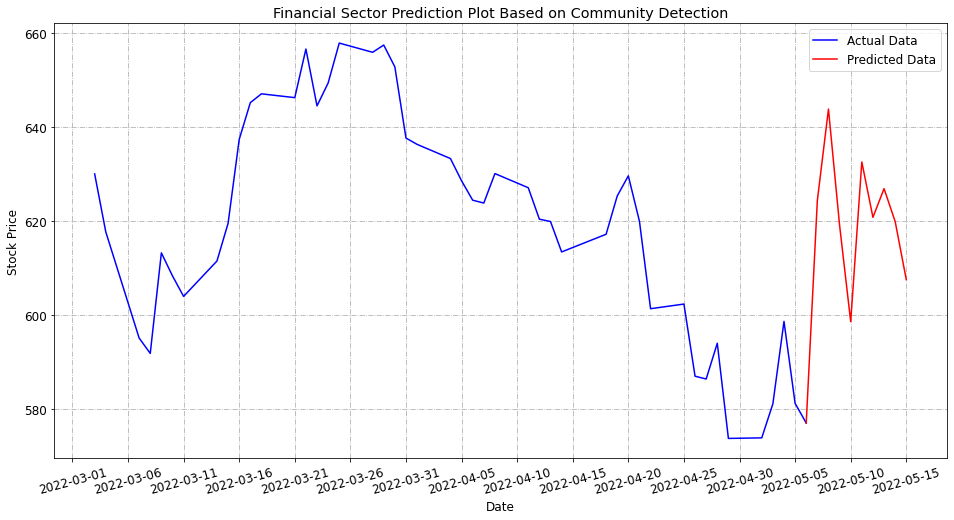

In [945]:
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Financial Sector Prediction Plot Based on Community Detection")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.1.2 Yahoo Finance
- tickers = ['axp', 'bac', 'blk', 'c', 'cof', 'gs', 'jpm', 'ms', 'usb', 'wfc']

In [990]:
# import dataset of sector index and sentiment score
tickers = ['axp', 'bac', 'blk', 'c', 'cof', 'gs', 'jpm', 'ms', 'usb', 'wfc']
sector = 'financial'
df_fin_yahoo = import_dataset(tickers, sector)
df_fin_yahoo

close_price  polarity_axp  polarity_bac  polarity_blk  polarity_c  \
date                                                                            
2022-03-07      595.060         0.463         0.236         0.243       0.425   
2022-03-08      591.790         0.120         0.229        -0.045       0.402   
2022-03-09      613.180         0.664         0.361         0.243       0.529   
2022-03-10      608.280         0.533         0.231         0.368       0.300   
2022-03-11      603.920         0.075         0.181         0.022       0.342   
2022-03-14      611.450         0.433         0.225         0.220       0.423   
2022-03-15      619.460         0.506         0.213         0.085       0.264   
2022-03-16      637.310         0.795         0.213        -0.004       0.312   
2022-03-17      645.140         0.122         0.303         0.470       0.532   
2022-03-21      646.210         0.508         0.159         0.119       0.179   
2022-03-23      644.460        -0.200         0.314         0.080       0.462   
2022-03-24      649.330        -0.103         0.140        -0.008       0.376   
2022-03-28      655.860        -0.300         0.383         0.319       0.100   
2022-03-29      657.400         0.233         0.202         0.385       0.299   
2022-03-30      652.760         0.178         0.221         0.222       0.200   
2022-03-31      637.610         0.622         0.173         0.278       0.203   
2022-04-04      633.250         0.005         0.211         0.213       0.341   
2022-04-05      628.520        -0.040         0.097         0.285       0.139   
2022-04-06      624.390         0.714         0.213         0.508       0.117   
2022-04-07      623.780         0.125         0.166         0.245       0.284   
2022-04-08      630.050         0.561         0.119         0.224       0.313   
2022-04-11      627.040         0.295         0.086         0.313       0.175   
2022-04-12      620.350         0.554         0.130         0.207       0.418   
2022-04-13      619.850         0.433         0.084         0.172       0.165   
2022-04-14      613.380         0.850         0.178         0.121       0.131   
2022-04-18      617.140        -0.056         0.150         0.014       0.233   
2022-04-19      625.280         0.616         0.221         0.169       0.326   
2022-04-20      629.570         0.753         0.209         0.232       0.489   
2022-04-21      619.900         0.196         0.105         0.176       0.358   
2022-04-22      601.300         0.172         0.248         0.225       0.208   
2022-04-25      602.290         0.164         0.154         0.348       0.325   
2022-04-26      586.940         0.110         0.358         0.316       0.588   
2022-04-27      586.340         0.595         0.125         0.437       0.146   
2022-04-28      593.950         0.702         0.398         0.583       0.584   
2022-04-29      573.700         0.545         0.230         0.255       0.516   
2022-05-02      573.820         0.422         0.207         0.380       0.264   
2022-05-03      581.060         0.458         0.169         0.722       0.405   
2022-05-04      598.600         0.526         0.206         0.667       0.366   
2022-05-05      581.150         0.500         0.363         0.442       0.302   

            polarity_cof  polarity_gs  polarity_jpm  polarity_ms  \
date                                                               
2022-03-07         0.630       -0.003         0.160        0.104   
2022-03-08         0.200        0.290         0.209        0.068   
2022-03-09         0.778        0.163         0.065        0.050   
2022-03-10         0.900        0.408         0.084        0.029   
2022-03-11         0.030       -0.001        -0.020        0.008   
2022-03-14         0.733        0.278         0.077        0.085   
2022-03-15         0.481        0.313         0.252       -0.078   
2022-03-16         0.444        0.409         0.313        0.030   
2022-03-17

In [991]:
x = df_fin_yahoo.iloc[:, 1:11].values # close price
y = df_fin_yahoo.iloc[:, 0].values # 10 stocks' sentiment score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(31, 10) (8, 10)


In [992]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [993]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[629.9751  628.51526 629.6848  597.13318 606.2561  624.58908 622.13618
 625.06594]
(8,)


In [998]:
# Model Performance
mae_fin_yahoo = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_fin_yahoo = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_fin_yahoo = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_fin_yahoo = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_fin_yahoo = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_fin_yahoo)
print("Mean Squared Error:", mse_fin_yahoo)
print("Root Mean Squared Error:", rmse_fin_yahoo)
print("(R^2) Score:", r2_fin_yahoo)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_fin_yahoo, '%.') 

Mean Absolute Error: 16.6604
Mean Squared Error: 400.6127
Root Mean Squared Error: 20.0153
(R^2) Score: -0.0246
Train Score : 83.18% and Test Score : -2.46% using Random Tree Regressor.
Accuracy: 97.24 %.


In [976]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_fin_yahoo.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-05          630.087
2022-05-06          628.515
2022-05-07          629.685
2022-05-08          597.120
2022-05-09          606.308
2022-05-10          624.632
2022-05-11          622.136
2022-05-12          625.079

In [979]:
df_pred = pd.concat([df_fin_yahoo['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-05'] = df_pred['actual_price']['2022-05-05']
df_pred.tail()

actual_price  predicted_price
date                                     
2022-05-08           NaN          597.120
2022-05-09           NaN          606.308
2022-05-10           NaN          624.632
2022-05-11           NaN          622.136
2022-05-12           NaN          625.079

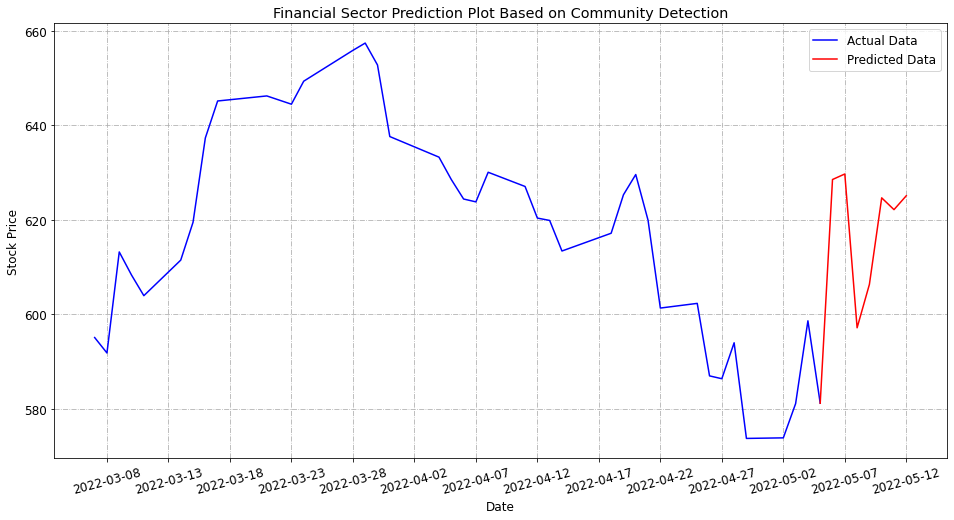

In [978]:
# Visualization for Stock Price Prediction
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Financial Sector Prediction Plot Based on Yahoo Finance")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.1.3 Comparison of Model Performance between Yahoo Finance and Community Detection

In [1077]:
data_perf = {'MAE': [mae_fin_yahoo, 
                                     mae_fin_comm], 
             'MSE': [mse_fin_yahoo, 
                                    mse_fin_comm],
             'RMSE': [rmse_fin_yahoo, 
                                         rmse_fin_comm],
             'Accuracy (%)': [accuracy_fin_yahoo, 
                          accuracy_fin_comm]}

df_perf = pd.DataFrame(data_perf, index=['Yahoo Finance', 
                                       'Community Detection'])
pd.set_option('display.float_format', '{:.3f}'.format)
df_perf.style.set_table_attributes("style='display:inline'").set_caption("Comparison of Model Performance between Yahoo Finance and Community Detectionn")
pd.set_option('display.precision', 3)
df_perf

MAE     MSE   RMSE  Accuracy (%)
Yahoo Finance       16.660 400.613 20.015        97.240
Community Detection 16.760 421.725 20.536        97.350

## 3.2 Health Care

### 3.2.1 Community Detection
- com_1_1_1 = ['aapl', 'abbv', 'amgn', 'chtr', 'gm', 'mrk', 'orcl', 'sbux', 'unh', 'usb']

In [1028]:
# import dataset of sector index and sentiment score
tickers = com_1_1_1
sector = 'healthcare'
df_health_comm = import_dataset(tickers, sector)
df_health_comm.replace(',','', regex=True, inplace=True)
df_health_comm['close_price'] = df_health_comm['close_price'].astype(float)
df_health_comm

close_price  polarity_aapl  polarity_abbv  polarity_amgn  \
date                                                                   
2022-03-07     1516.150          0.077         -0.124          0.090   
2022-03-08     1484.120          0.163          0.183          0.024   
2022-03-09     1512.290          0.068          0.034          0.312   
2022-03-10     1511.860          0.084          0.250          0.436   
2022-03-11     1499.910          0.053          0.161          0.300   
2022-03-14     1510.150          0.117          0.343          0.611   
2022-03-15     1539.280          0.114          0.244          0.500   
2022-03-16     1558.130          0.044          0.402          0.833   
2022-03-17     1583.160          0.097          0.367          0.267   
2022-03-21     1591.590          0.123          0.193          0.025   
2022-03-24     1581.620          0.067          0.406         -0.067   
2022-03-28     1601.480          0.085          0.448          0.396   
2022-03-30     1613.900          0.095          0.254          0.250   
2022-03-31     1594.810          0.068          0.379          0.619   
2022-04-04     1597.220          0.141          0.176          0.396   
2022-04-05     1600.090          0.099          0.266          0.180   
2022-04-06     1624.870          0.087          0.201          0.455   
2022-04-07     1655.010          0.119          0.185          0.414   
2022-04-08     1664.580          0.098          0.211          0.667   
2022-04-11     1631.840          0.107          0.264          0.122   
2022-04-12     1616.380          0.076          0.183          0.400   
2022-04-13     1623.310          0.096          0.205          0.267   
2022-04-14     1615.790          0.115          0.248          0.483   
2022-04-18     1597.730          0.115          0.237          0.422   
2022-04-19     1612.580          0.094          0.210          0.444   
2022-04-20     1634.240          0.088          0.236          0.571   
2022-04-21     1616.160          0.085          0.355          0.250   
2022-04-22     1557.490          0.124          0.243          0.062   
2022-04-25     1567.840          0.123          0.220          0.371   
2022-04-26     1538.040          0.116          0.567          0.451   
2022-04-27     1536.240          0.121          0.314          0.122   
2022-04-28     1557.000          0.018          0.383          0.119   
2022-04-29     1518.450          0.077          0.180          0.173   
2022-05-02     1508.120          0.047          0.286          0.413   
2022-05-03     1513.200          0.057          0.449          0.736   
2022-05-04     1546.460          0.083          0.400          0.417   
2022-05-05     1516.140          0.079          0.339          0.521   

            polarity_chtr  polarity_gm  polarity_mrk  polarity_orcl  \
date                                                                  
2022-03-07          0.491        0.204         0.351          0.457   
2022-03-08          0.500        0.499         0.285          0.311   
2022-03-09          1.000        0.138         0.266          0.330   
2022-03-10          0.851        0.274         0.232          0.083   
2022-03-11          0.762        0.319         0.212          0.110   
2022-03-14          0.333        0.365         0.215          0.273   
2022-03-15          0.533        0.393         0.171          0.325   
2022-03-16          0.750        0.275         0.172          0.309   
2022-03-17          0.220        0.582         0.295          0.089   
2022-03-21          1.000        0.380         0.506          0.630   
2022-03-24          1.000        0.226         0.220          0.111   
2022-03-28          0.556        0.196         0.167         -0.333   
2022-03-30          0.320        0.409         0.225          0.371   
2022-03-31          0.067        0.069         0.515          0.821   
2022-04-04          0.461        0.135         0.429          0.546

In [1029]:
x = df_health_comm.iloc[:, 1:11].values # close price
y = df_health_comm.iloc[:, 0].values # 10 stocks' sentiment score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(29, 10) (8, 10)


In [1030]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1031]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[1579.07476667 1555.87822    1595.37374667 1553.5624     1546.59518
 1564.2325     1576.60602    1573.28052   ]
(8,)


In [1032]:
# Model Performance

mae_health_comm = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_health_comm = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_health_comm = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_health_comm = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_health_comm = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_health_comm)
print("Mean Squared Error:", mse_health_comm)
print("Root Mean Squared Error:", rmse_health_comm)
print("(R^2) Score:", r2_health_comm)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_health_comm, '%.') 

Mean Absolute Error: 27.5583
Mean Squared Error: 1016.7142
Root Mean Squared Error: 31.886
(R^2) Score: -0.9334
Train Score : 86.01% and Test Score : -93.34% using Random Tree Regressor.
Accuracy: 98.28 %.


In [1033]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_health_comm.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-05         1579.075
2022-05-06         1555.878
2022-05-07         1595.374
2022-05-08         1553.562
2022-05-09         1546.595
2022-05-10         1564.233
2022-05-11         1576.606
2022-05-12         1573.281

In [1035]:
df_pred = pd.concat([df_health_comm['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-05'] = df_pred['actual_price']['2022-05-05']
df_pred

actual_price  predicted_price
date                                     
2022-03-07      1516.150              NaN
2022-03-08      1484.120              NaN
2022-03-09      1512.290              NaN
2022-03-10      1511.860              NaN
2022-03-11      1499.910              NaN
2022-03-14      1510.150              NaN
2022-03-15      1539.280              NaN
2022-03-16      1558.130              NaN
2022-03-17      1583.160              NaN
2022-03-21      1591.590              NaN
2022-03-24      1581.620              NaN
2022-03-28      1601.480              NaN
2022-03-30      1613.900              NaN
2022-03-31      1594.810              NaN
2022-04-04      1597.220              NaN
2022-04-05      1600.090              NaN
2022-04-06      1624.870              NaN
2022-04-07      1655.010              NaN
2022-04-08      1664.580              NaN
2022-04-11      1631.840              NaN
2022-04-12      1616.380              NaN
2022-04-13      1623.310              NaN
2022-04-14      1615.790              NaN
2022-04-18      1597.730              NaN
2022-04-19      1612.580              NaN
2022-04-20      1634.240              NaN
2022-04-21      1616.160              NaN
2022-04-22      1557.490              NaN
2022-04-25      1567.840              NaN
2022-04-26      1538.040              NaN
2022-04-27      1536.240              NaN
2022-04-28      1557.000              NaN
2022-04-29      1518.450              NaN
2022-05-02      1508.120              NaN
2022-05-03      1513.200              NaN
2022-05-04      1546.460              NaN
2022-05-05      1516.140         1516.140
2022-05-06           NaN         1555.878
2022-05-07           NaN         1595.374
2022-05-08           NaN         1553.562
2022-05-09           NaN         1546.595
2022-05-10           NaN         1564.233
2022-05-11           NaN         1576.606
2022-05-12           NaN         1573.281

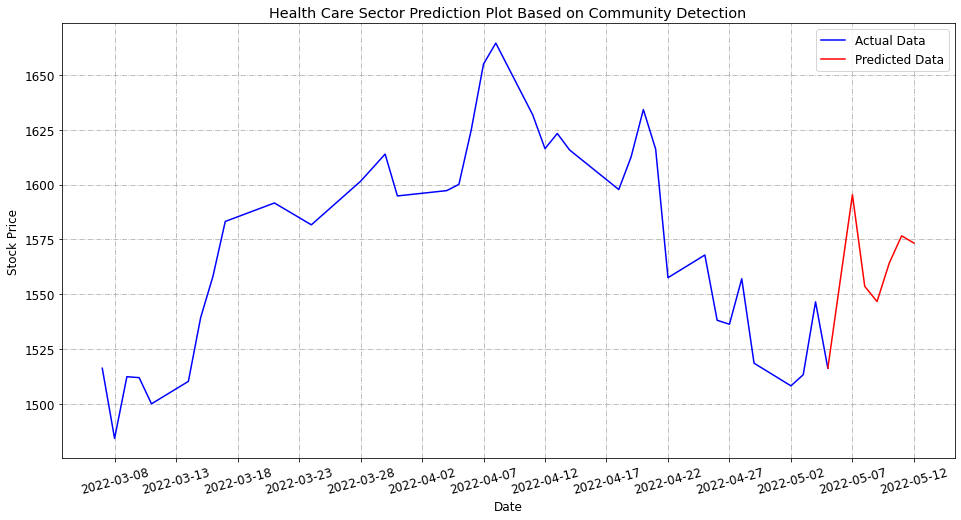

In [1036]:
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Health Care Sector Prediction Plot Based on Community Detection")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.2.2 Yahoo Finance
- tickers = ['abbv','abt','amgn','bmy','cvs','jnj','mdt','mrk','pfe','unh']

In [1049]:
# import dataset of sector index and sentiment score
tickers = ['abbv','abt','amgn','bmy','cvs','jnj','mdt','mrk','pfe','unh']
sector = 'healthcare'
df_health_yahoo = import_dataset(tickers, sector)
df_health_yahoo.replace(',','', regex=True, inplace=True)
df_health_yahoo['close_price'] = df_health_yahoo['close_price'].astype(float)
df_health_yahoo

close_price  polarity_abbv  polarity_abt  polarity_amgn  \
date                                                                  
2022-03-03     1535.010          0.078        -0.043          0.455   
2022-03-04     1542.540          0.388         0.919          0.181   
2022-03-07     1516.150         -0.124         0.228          0.090   
2022-03-08     1484.120          0.183         1.000          0.024   
2022-03-09     1512.290          0.034         0.650          0.312   
2022-03-10     1511.860          0.250         0.200          0.436   
2022-03-11     1499.910          0.161         0.182          0.300   
2022-03-14     1510.150          0.343         0.109          0.611   
2022-03-15     1539.280          0.244         0.296          0.500   
2022-03-16     1558.130          0.402         0.270          0.833   
2022-03-17     1583.160          0.367         0.456          0.267   
2022-03-18     1593.480          0.242         0.077          0.667   
2022-03-21     1591.590          0.193         0.111          0.025   
2022-03-22     1591.840          0.367         0.467          0.448   
2022-03-23     1563.680          0.410         0.112          0.758   
2022-03-24     1581.620          0.406         0.204         -0.067   
2022-03-25     1589.780          0.184        -0.043          0.262   
2022-03-28     1601.480          0.448         0.564          0.396   
2022-03-29     1610.340          0.447         0.203          0.150   
2022-03-30     1613.900          0.254         0.408          0.250   
2022-03-31     1594.810          0.379         0.500          0.619   
2022-04-01     1609.250          0.314         0.335          1.000   
2022-04-04     1597.220          0.176         0.597          0.396   
2022-04-05     1600.090          0.266         0.175          0.180   
2022-04-06     1624.870          0.201         0.667          0.455   
2022-04-07     1655.010          0.185         0.542          0.414   
2022-04-08     1664.580          0.211         0.381          0.667   
2022-04-11     1631.840          0.264         0.833          0.122   
2022-04-12     1616.380          0.183         0.260          0.400   
2022-04-13     1623.310          0.205         0.050          0.267   
2022-04-14     1615.790          0.248         0.371          0.483   
2022-04-18     1597.730          0.237         0.287          0.422   
2022-04-19     1612.580          0.210         0.337          0.444   
2022-04-20     1634.240          0.236         0.211          0.571   
2022-04-21     1616.160          0.355         0.375          0.250   
2022-04-22     1557.490          0.243         0.495          0.062   
2022-04-25     1567.840          0.220         0.427          0.371   
2022-04-26     1538.040          0.567         0.460          0.451   
2022-04-27     1536.240          0.314         0.595          0.122   
2022-04-28     1557.000          0.383         0.578          0.119   
2022-04-29     1518.450          0.180         0.130          0.173   
2022-05-02     1508.120          0.286         0.508          0.413   
2022-05-03     1513.200          0.449         0.403          0.736   
2022-05-04     1546.460          0.400         0.369          0.417   
2022-05-05     1516.140          0.339         0.468          0.521   
2022-05-06     1511.650          0.375         0.733          0.628   

            polarity_bmy  polarity_cvs  polarity_jnj  polarity_mdt  \
date                                                                 
2022-03-03         0.312         0.391         0.151         0.077   
2022-03-04         0.351         0.488        -0.008         0.177   
2022-03-07         0.308         0.591         0.181         0.300   
2022-03-08         0.271         0.324         0.024         0.439   
2022-03-09         0.524         0.704         0.046         0.010   
2022-03-10         0.363         0.505        -0.052         0.375   
2022-03-11         0.108         0.156     

In [1050]:
x = df_health_yahoo.iloc[:, 1:11].values # close price
y = df_health_yahoo.iloc[:, 0].values # 10 stocks' sentiment score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(36, 10) (10, 10)


In [1051]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1054]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[1540.492404 1586.35174  1580.564    1541.67094  1592.49184  1593.89828
 1597.74534  1540.54828  1533.20697  1575.02448 ]
(10,)


In [1064]:
# Model Performance
mae_health_yahoo = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_health_yahoo = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_health_yahoo = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_health_yahoo = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_health_yahoo = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_health_yahoo)
print("Mean Squared Error:", mse_health_yahoo)
print("Root Mean Squared Error:", rmse_health_yahoo)
print("(R^2) Score:", r2_health_yahoo)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_health_yahoo, '%.') 

Mean Absolute Error: 38.1401
Mean Squared Error: 2414.0859
Root Mean Squared Error: 49.1333
(R^2) Score: -1.0058
Train Score : 83.85% and Test Score : -100.58% using Random Tree Regressor.
Accuracy: 97.63 %.


In [1056]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_health_yahoo.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06         1540.492
2022-05-07         1586.352
2022-05-08         1580.564
2022-05-09         1541.671
2022-05-10         1592.492
2022-05-11         1593.898
2022-05-12         1597.745
2022-05-13         1540.548
2022-05-14         1533.207
2022-05-15         1575.024

In [1057]:
df_pred = pd.concat([df_health_yahoo['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred.tail()

actual_price  predicted_price
date                                     
2022-05-11           NaN         1593.898
2022-05-12           NaN         1597.745
2022-05-13           NaN         1540.548
2022-05-14           NaN         1533.207
2022-05-15           NaN         1575.024

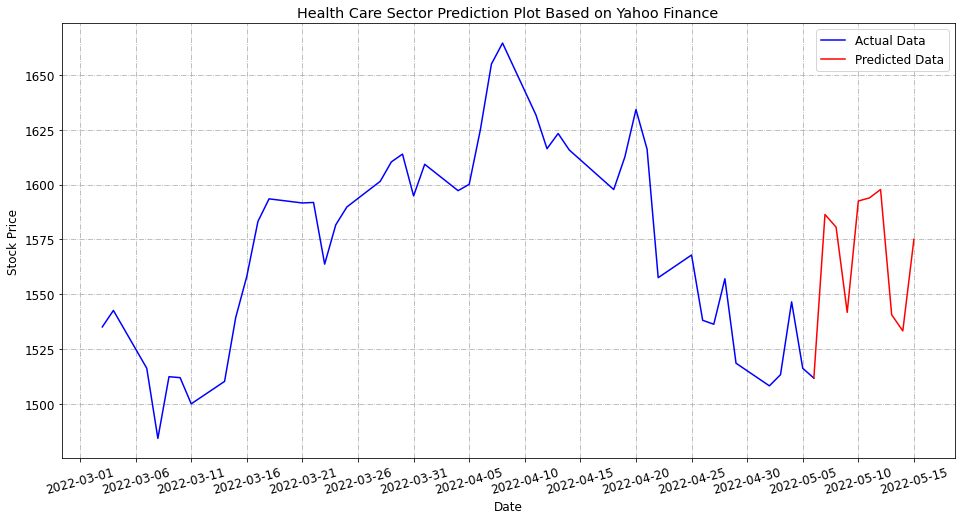

In [1058]:
# Visualization for Stock Price Prediction
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Health Care Sector Prediction Plot Based on Yahoo Finance")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.2.3 Comparison of Model Performance between Yahoo Finance and Community Detection

In [1076]:
data_perf = {'MAE': [mae_health_yahoo, 
                                     mae_health_comm], 
             'MSE': [mse_health_yahoo, 
                                    mse_health_comm],
             'RMSE': [rmse_health_yahoo, 
                                         rmse_health_comm],
             'Accuracy (%)': [accuracy_health_yahoo, 
                          accuracy_health_comm]}

df_perf = pd.DataFrame(data_perf, index=['Yahoo Finance', 
                                         'Community Detection'])
df_perf.style.set_table_attributes("style='display:inline'").set_caption("Comparison of Model Performance between Yahoo Finance and Community Detectionn")
pd.set_option('display.precision', 3)
df_perf

MAE       MSE   RMSE  Accuracy (%)
Yahoo Finance       38.140 2,414.086 49.133        97.630
Community Detection 27.558 1,016.714 31.886        98.280

## 3.3 Consumer Discretionary

### 3.3.1 Community Detection
- com_2 = ['adbe', 'amzn', 'c', 'cvs', 'dis', 'fb', 'foxa', 'intc', 'nflx', 'wfc']

In [1091]:
# import dataset of sector index and sentiment score
tickers = com_2
sector = 'consumerdiscretionary'
df_consumer_comm = import_dataset(tickers, sector)
df_consumer_comm.replace(',','', regex=True, inplace=True)
df_consumer_comm['close_price'] = df_consumer_comm['close_price'].astype(float)
df_consumer_comm

close_price  polarity_adbe  polarity_amzn  polarity_c  \
date                                                                
2022-03-03     1371.330          0.503          0.043       0.376   
2022-03-07     1285.790          0.533          0.042       0.425   
2022-03-08     1286.510          0.437          0.082       0.402   
2022-03-09     1324.230          0.604         -0.011       0.529   
2022-03-10     1339.590          0.332          0.005       0.300   
2022-03-11     1315.580          0.595          0.038       0.342   
2022-03-14     1292.550          0.577          0.061       0.423   
2022-03-15     1336.340          0.482          0.069       0.264   
2022-03-16     1381.120          0.375          0.045       0.312   
2022-03-18     1437.520          0.254          0.104       0.387   
2022-03-21     1426.620          0.251          0.144       0.179   
2022-03-22     1461.510          0.033          0.140       0.166   
2022-03-23     1443.520          0.113          0.131       0.462   
2022-03-25     1452.850          0.062          0.006       0.229   
2022-03-28     1491.670          0.171          0.041       0.100   
2022-03-29     1514.670          0.044          0.094       0.299   
2022-03-30     1491.740          0.300          0.071       0.200   
2022-03-31     1462.690          0.276          0.060       0.203   
2022-04-01     1465.810          0.433          0.022       0.382   
2022-04-04     1499.930          0.147          0.108       0.341   
2022-04-05     1464.660          0.096          0.109       0.139   
2022-04-06     1426.110          0.536          0.090       0.117   
2022-04-07     1431.670          0.289          0.076       0.284   
2022-04-11     1390.930          0.646          0.054       0.175   
2022-04-12     1393.730          0.033         -0.026       0.418   
2022-04-14     1406.280          0.109          0.014       0.131   
2022-04-18     1411.010          0.211          0.100       0.233   
2022-04-19     1452.090          0.413          0.076       0.326   
2022-04-20     1432.400          0.268          0.082       0.489   
2022-04-21     1414.750          0.284          0.060       0.358   
2022-04-25     1391.880          0.544          0.056       0.325   
2022-04-26     1322.470          0.210          0.095       0.588   
2022-04-28     1352.180          0.444          0.010       0.584   
2022-05-03     1285.710          0.269          0.024       0.405   
2022-05-04     1322.390          0.187         -0.005       0.366   
2022-05-05     1245.490          0.375         -0.008       0.302   
2022-05-06     1229.220          0.224          0.007       0.355   

            polarity_cvs  polarity_dis  polarity_fb  polarity_foxa  \
date                                                                 
2022-03-03         0.391         0.075        0.080         -0.375   
2022-03-07         0.591         0.022        0.057         -0.500   
2022-03-08         0.324         0.114        0.063          0.701   
2022-03-09         0.704         0.252        0.098          0.000   
2022-03-10         0.505         0.113        0.078          0.387   
2022-03-11         0.156        -0.042        0.079         -0.167   
2022-03-14         0.487         0.107        0.102          0.667   
2022-03-15         0.402         0.240        0.055          0.619   
2022-03-16         0.198         0.191        0.151          0.000   
2022-03-18         0.304         0.172        0.128          0.556   
2022-03-21         0.194         0.043        0.180         -1.000   
2022-03-22         0.737         0.065        0.139          0.000   
2022-03-23         0.718         0.153        0.085          0.000   
2022-03-25         0.380         0.155        0.204          0.554   
2022-03-28         0.032         0.102        0.112          0.000   
2022-03-29         0.414         0.204        0.137          0.500   
2022-03-30         0.360         0.140        0.107         

In [1092]:
x = df_consumer_comm.iloc[:, 1:11].values # close price
y = df_consumer_comm.iloc[:, 0].values # 10 stocks' sentiment score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(29, 10) (8, 10)


In [1093]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1102]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[1332.7673  1446.64712 1428.8109  1405.92382 1402.181   1375.18872
 1429.96438 1433.21584]
(8,)


In [1103]:
# Model Performance

mae_consumer_comm = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_consumer_comm = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_consumer_comm = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_consumer_comm = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_consumer_comm = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_consumer_comm)
print("Mean Squared Error:", mse_consumer_comm)
print("Root Mean Squared Error:", rmse_consumer_comm)
print("(R^2) Score:", r2_consumer_comm)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_consumer_comm, '%.') 

Mean Absolute Error: 56.3079
Mean Squared Error: 4012.1484
Root Mean Squared Error: 63.3415
(R^2) Score: -0.374
Train Score : 88.15% and Test Score : -37.40% using Random Tree Regressor.
Accuracy: 96.08 %.


In [1104]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_consumer_comm.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06         1332.767
2022-05-07         1446.647
2022-05-08         1428.811
2022-05-09         1405.924
2022-05-10         1402.181
2022-05-11         1375.189
2022-05-12         1429.964
2022-05-13         1433.216

In [1105]:
df_pred = pd.concat([df_consumer_comm['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-03      1371.330              NaN
2022-03-07      1285.790              NaN
2022-03-08      1286.510              NaN
2022-03-09      1324.230              NaN
2022-03-10      1339.590              NaN
2022-03-11      1315.580              NaN
2022-03-14      1292.550              NaN
2022-03-15      1336.340              NaN
2022-03-16      1381.120              NaN
2022-03-18      1437.520              NaN
2022-03-21      1426.620              NaN
2022-03-22      1461.510              NaN
2022-03-23      1443.520              NaN
2022-03-25      1452.850              NaN
2022-03-28      1491.670              NaN
2022-03-29      1514.670              NaN
2022-03-30      1491.740              NaN
2022-03-31      1462.690              NaN
2022-04-01      1465.810              NaN
2022-04-04      1499.930              NaN
2022-04-05      1464.660              NaN
2022-04-06      1426.110              NaN
2022-04-07      1431.670              NaN
2022-04-11      1390.930              NaN
2022-04-12      1393.730              NaN
2022-04-14      1406.280              NaN
2022-04-18      1411.010              NaN
2022-04-19      1452.090              NaN
2022-04-20      1432.400              NaN
2022-04-21      1414.750              NaN
2022-04-25      1391.880              NaN
2022-04-26      1322.470              NaN
2022-04-28      1352.180              NaN
2022-05-03      1285.710              NaN
2022-05-04      1322.390              NaN
2022-05-05      1245.490              NaN
2022-05-06      1229.220         1229.220
2022-05-07           NaN         1446.647
2022-05-08           NaN         1428.811
2022-05-09           NaN         1405.924
2022-05-10           NaN         1402.181
2022-05-11           NaN         1375.189
2022-05-12           NaN         1429.964
2022-05-13           NaN         1433.216

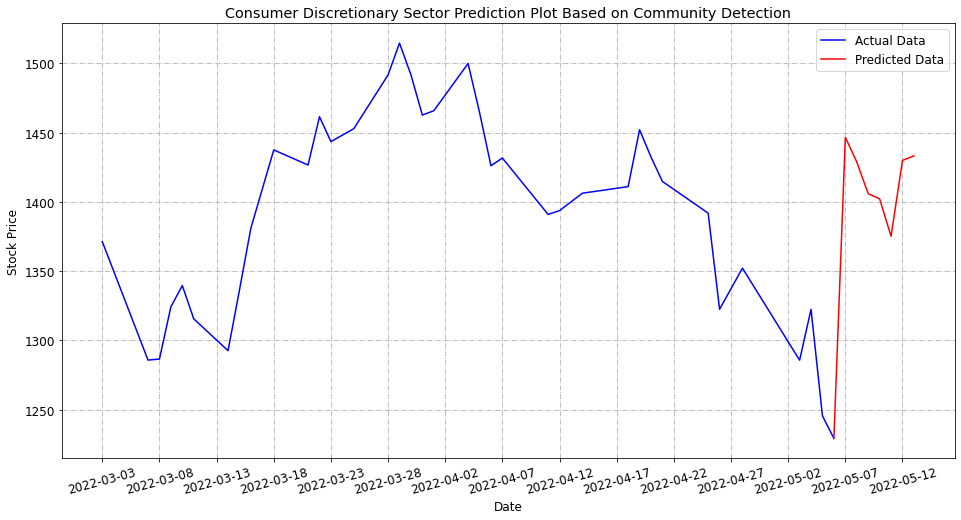

In [1106]:
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Consumer Discretionary Sector Prediction Plot Based on Community Detection")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.3.2 Yahoo Finance
- tickers = ['amzn', 'f', 'gm', 'hd','low', 'mcd', 'nke', 'sbux', 'tgt', 'tsla']

In [1108]:
# import dataset of sector index and sentiment score
tickers = ['amzn', 'f', 'gm', 'hd','low', 'mcd', 'nke', 'sbux', 'tgt', 'tsla']
sector = 'consumerdiscretionary'
df_consumer_yahoo = import_dataset(tickers, sector)
df_consumer_yahoo.replace(',','', regex=True, inplace=True)
df_consumer_yahoo['close_price'] = df_consumer_yahoo['close_price'].astype(float)
df_consumer_yahoo

close_price  polarity_amzn  polarity_f  polarity_gm  polarity_hd  \
date                                                                           
2022-03-02     1403.510          0.056       0.158        0.218        0.181   
2022-03-03     1371.330          0.043       0.167        0.312        0.263   
2022-03-04     1350.600          0.103       0.082        0.064        0.507   
2022-03-07     1285.790          0.042       0.179        0.204        0.428   
2022-03-08     1286.510          0.082       0.107        0.499        0.233   
2022-03-09     1324.230         -0.011       0.083        0.138        0.173   
2022-03-10     1339.590          0.005       0.174        0.274        0.335   
2022-03-11     1315.580          0.038       0.154        0.319        0.482   
2022-03-14     1292.550          0.061       0.203        0.365        0.101   
2022-03-15     1336.340          0.069       0.123        0.393        0.514   
2022-03-16     1381.120          0.045       0.170        0.275        0.532   
2022-03-17     1406.860          0.053       0.093        0.582        0.574   
2022-03-18     1437.520          0.104       0.033        0.302        0.233   
2022-03-21     1426.620          0.144       0.193        0.380        0.096   
2022-03-22     1461.510          0.140       0.244        0.355        0.051   
2022-03-23     1443.520          0.131       0.080        0.288        0.035   
2022-03-24     1454.100          0.016       0.192        0.226        0.133   
2022-03-25     1452.850          0.006       0.045        0.033        0.241   
2022-03-28     1491.670          0.041       0.077        0.196        0.219   
2022-03-29     1514.670          0.094       0.161        0.471        0.226   
2022-03-30     1491.740          0.071       0.186        0.409        0.122   
2022-03-31     1462.690          0.060       0.145        0.069        0.068   
2022-04-01     1465.810          0.022       0.101        0.333        0.068   
2022-04-04     1499.930          0.108       0.156        0.135        0.152   
2022-04-05     1464.660          0.109       0.127        0.328        0.262   
2022-04-06     1426.110          0.090       0.184        0.287        0.246   
2022-04-07     1431.670          0.076       0.142        0.146        0.118   
2022-04-08     1417.790          0.014       0.224        0.321        0.263   
2022-04-11     1390.930          0.054       0.153        0.275        0.183   
2022-04-12     1393.730         -0.026       0.177        0.334        0.113   
2022-04-13     1428.730          0.010       0.099        0.055        0.173   
2022-04-14     1406.280          0.014       0.127        0.203        0.327   
2022-04-18     1411.010          0.100       0.033        0.178        0.159   
2022-04-19     1452.090          0.076       0.080        0.359        0.472   
2022-04-20     1432.400          0.082       0.114        0.396        0.383   
2022-04-21     1414.750          0.060       0.073        0.433        0.202   
2022-04-22     1381.160          0.040       0.143        0.342        0.376   
2022-04-25     1391.880          0.056       0.123        0.367        0.239   
2022-04-26     1322.470          0.095       0.097        0.172        0.191   
2022-04-27     1321.530          0.094       0.057        0.149        0.492   
2022-04-28     1352.180          0.010       0.132        0.205        0.179   
2022-04-29     1272.150          0.030       0.117        0.309        0.360   
2022-05-02     1289.460          0.019       0.035        0.078        0.486   
2022-05-03     1285.710          0.024       0.141        0.233        0.415   
2022-05-04     1322.390         -0.005       0.077        0.476        0.292   
2022-05-05     1245.490         -0.008       0.152        0.160        0.404   
2022-05-06     1229.220          0.007       0.061        0.169        0.232   

            polarity_low  polarity_mcd  polarity_nke  polarity_sbux  \
date                

In [1109]:
x = df_consumer_yahoo.iloc[:, 1:11].values # close price
y = df_consumer_yahoo.iloc[:, 0].values # 10 stocks' sentiment score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(37, 10) (10, 10)


In [1110]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1119]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[1366.93542    1383.0304     1360.84796    1436.88874    1377.64448
 1357.91032    1313.07284    1327.7824     1406.97036667 1343.42424   ]
(10,)


In [1120]:
# Model Performance
mae_consumer_yahoo = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_consumer_yahoo = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_consumer_yahoo = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_consumer_yahoo = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_consumer_yahoo = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_consumer_yahoo)
print("Mean Squared Error:", mse_consumer_yahoo)
print("Root Mean Squared Error:", rmse_consumer_yahoo)
print("(R^2) Score:", r2_consumer_yahoo)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_consumer_yahoo, '%.') 

Mean Absolute Error: 67.2936
Mean Squared Error: 5956.7108
Root Mean Squared Error: 77.1797
(R^2) Score: -0.4217
Train Score : 86.50% and Test Score : -42.17% using Random Tree Regressor.
Accuracy: 95.18 %.


In [1121]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_consumer_yahoo.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06         1366.935
2022-05-07         1383.030
2022-05-08         1360.848
2022-05-09         1436.889
2022-05-10         1377.644
2022-05-11         1357.910
2022-05-12         1313.073
2022-05-13         1327.782
2022-05-14         1406.970
2022-05-15         1343.424

In [1123]:
df_pred = pd.concat([df_consumer_yahoo['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-02      1403.510              NaN
2022-03-03      1371.330              NaN
2022-03-04      1350.600              NaN
2022-03-07      1285.790              NaN
2022-03-08      1286.510              NaN
2022-03-09      1324.230              NaN
2022-03-10      1339.590              NaN
2022-03-11      1315.580              NaN
2022-03-14      1292.550              NaN
2022-03-15      1336.340              NaN
2022-03-16      1381.120              NaN
2022-03-17      1406.860              NaN
2022-03-18      1437.520              NaN
2022-03-21      1426.620              NaN
2022-03-22      1461.510              NaN
2022-03-23      1443.520              NaN
2022-03-24      1454.100              NaN
2022-03-25      1452.850              NaN
2022-03-28      1491.670              NaN
2022-03-29      1514.670              NaN
2022-03-30      1491.740              NaN
2022-03-31      1462.690              NaN
2022-04-01      1465.810              NaN
2022-04-04      1499.930              NaN
2022-04-05      1464.660              NaN
2022-04-06      1426.110              NaN
2022-04-07      1431.670              NaN
2022-04-08      1417.790              NaN
2022-04-11      1390.930              NaN
2022-04-12      1393.730              NaN
2022-04-13      1428.730              NaN
2022-04-14      1406.280              NaN
2022-04-18      1411.010              NaN
2022-04-19      1452.090              NaN
2022-04-20      1432.400              NaN
2022-04-21      1414.750              NaN
2022-04-22      1381.160              NaN
2022-04-25      1391.880              NaN
2022-04-26      1322.470              NaN
2022-04-27      1321.530              NaN
2022-04-28      1352.180              NaN
2022-04-29      1272.150              NaN
2022-05-02      1289.460              NaN
2022-05-03      1285.710              NaN
2022-05-04      1322.390              NaN
2022-05-05      1245.490              NaN
2022-05-06      1229.220         1229.220
2022-05-07           NaN         1383.030
2022-05-08           NaN         1360.848
2022-05-09           NaN         1436.889
2022-05-10           NaN         1377.644
2022-05-11           NaN         1357.910
2022-05-12           NaN         1313.073
2022-05-13           NaN         1327.782
2022-05-14           NaN         1406.970
2022-05-15           NaN         1343.424

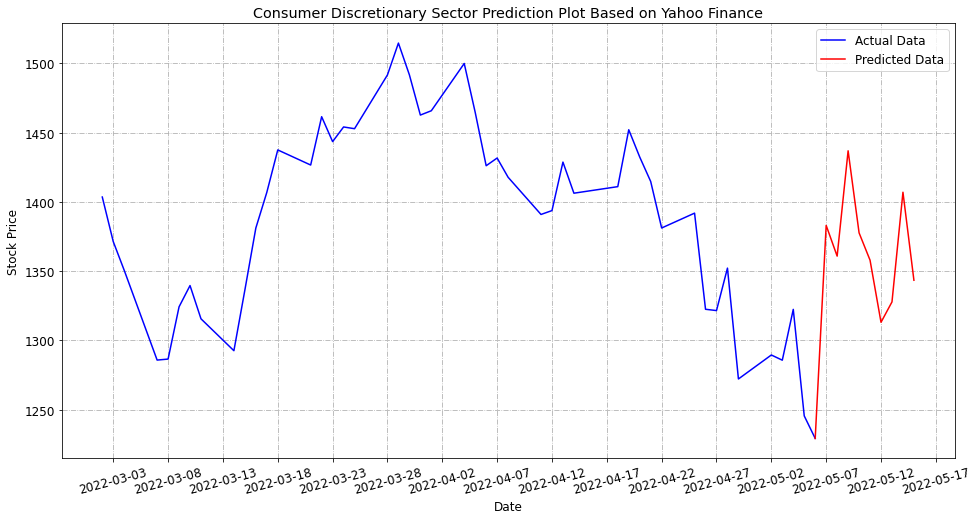

In [1124]:
# Visualization for Stock Price Prediction
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Consumer Discretionary Sector Prediction Plot Based on Yahoo Finance")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.3.3 Comparison of Model Performance between Yahoo Finance and Community Detection

In [1125]:
data_perf = {'MAE': [mae_consumer_yahoo, 
                                    mae_consumer_comm], 
             'MSE': [mse_consumer_yahoo, 
                                    mse_consumer_comm],
             'RMSE': [rmse_consumer_yahoo, 
                                         rmse_consumer_comm],
             'Accuracy (%)': [accuracy_consumer_yahoo, 
                          accuracy_consumer_comm]}

df_perf = pd.DataFrame(data_perf, index=['Yahoo Finance', 
                                         'Community Detection'])
df_perf.style.set_table_attributes("style='display:inline'").set_caption("Comparison of Model Performance between Yahoo Finance and Community Detectionn")
pd.set_option('display.precision', 3)
df_perf

MAE      MSE   RMSE  Accuracy (%)
Yahoo Finance       67.294 5956.711 77.180        95.180
Community Detection 56.308 4012.148 63.342        96.080

## 3.4 Communication Services

### 3.4.1 Community Detection
- com_1_2_2 = ['axp', 'cmcsa', 'cvs', 'dis', 'googl', 'gs', 'ibm', 'nflx', 'tgt', 'vz']


In [1206]:
# import dataset of sector index and sentiment score
tickers = com_1_2_2
sector = 'communicationservices'
df_commu_comm = import_dataset(tickers, sector)
df_commu_comm.replace(',','', regex=True, inplace=True)
df_commu_comm['close_price'] = df_commu_comm['close_price'].astype(float)
df_commu_comm

close_price  polarity_axp  polarity_cmcsa  polarity_cvs  \
date                                                                  
2022-03-03      229.920         0.303           0.297         0.391   
2022-03-04      226.710         0.372           0.444         0.488   
2022-03-07      218.220         0.463           0.372         0.591   
2022-03-08      217.970         0.120           0.020         0.324   
2022-03-09      225.490         0.664           0.600         0.704   
2022-03-10      223.800         0.533           0.120         0.505   
2022-03-11      219.590         0.075           0.600         0.156   
2022-03-14      215.610         0.433           0.443         0.487   
2022-03-15      220.450         0.506           0.660         0.402   
2022-03-16      226.900         0.795           0.500         0.198   
2022-03-17      229.020         0.122           0.329         0.219   
2022-03-18      232.310         0.380           0.159         0.304   
2022-03-21      230.770         0.508           0.514         0.194   
2022-03-22      235.400         0.333           0.500         0.737   
2022-03-23      232.470        -0.200           0.840         0.718   
2022-03-24      236.390        -0.103           0.250         0.357   
2022-03-25      237.300         0.294           0.549         0.380   
2022-03-28      237.940        -0.300           0.369         0.032   
2022-03-29      241.250         0.233           0.863         0.414   
2022-03-30      239.920         0.178           0.520         0.360   
2022-03-31      235.090         0.622           0.337         0.122   
2022-04-01      237.170         0.178           0.867         0.410   
2022-04-04      242.580         0.005          -0.009         0.319   
2022-04-05      239.220        -0.040           0.045         0.142   
2022-04-06      234.170         0.714           0.355         0.213   
2022-04-07      232.460         0.125           0.048         0.480   
2022-04-08      230.730         0.561           0.676         0.347   
2022-04-11      226.860         0.295           0.167         0.270   
2022-04-12      225.020         0.554           0.489         0.159   
2022-04-13      227.960         0.433           1.000         0.281   
2022-04-14      223.810         0.850           0.143         0.219   
2022-04-18      223.460        -0.056           0.406         0.444   
2022-04-19      228.080         0.616           0.160         0.817   
2022-04-20      218.800         0.753           0.164         0.542   
2022-04-21      213.520         0.196           0.000         0.476   
2022-04-22      206.480         0.172           0.069         0.603   
2022-04-25      209.630         0.164           0.299         0.571   
2022-04-26      203.000         0.110           0.399         0.603   
2022-04-27      197.690         0.595           0.506         0.424   
2022-04-28      205.370         0.702           0.107         0.387   
2022-04-29      198.030         0.545           0.286         0.404   
2022-05-02      202.830         0.422           0.700         0.307   
2022-05-03      203.920         0.458           0.537         0.290   
2022-05-04      211.420         0.526           0.595         0.256   
2022-05-05      202.780         0.500           0.424         0.299   
2022-05-06      200.130         0.519           0.139         0.430   

            polarity_dis  polarity_googl  polarity_gs  polarity_ibm  \
date                                                                  
2022-03-03         0.075           0.040        0.568         0.477   
2022-03-04         0.162           0.093        0.125         0.186   
2022-03-07         0.022           0.093       -0.003         0.033   
2022-03-08         0.114           0.253        0.290         0.607   
2022-03-09         0.252           0.133        0.163         0.562   
2022-03-10         0.113           0.142        0.408         0.372   
2022-03-11        -0.042           

In [1207]:
x = df_commu_comm.iloc[:, 1:11].values # close price
y = df_commu_comm.iloc[:, 0].values # 10 stocks' sentiment score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(36, 10) (10, 10)


In [1208]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1209]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=8, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[216.298298   218.43652    228.69226833 221.69518667 229.846624
 230.342998   226.67476667 225.95928667 217.76141    214.23948833]
(10,)


In [1210]:
# Model Performance

mae_commu_comm = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_commu_comm = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_commu_comm = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_commu_comm = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_commu_comm = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_commu_comm)
print("Mean Squared Error:", mse_commu_comm)
print("Root Mean Squared Error:", rmse_commu_comm)
print("(R^2) Score:", r2_commu_comm)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_commu_comm, '%.') 

Mean Absolute Error: 9.4287
Mean Squared Error: 145.3877
Root Mean Squared Error: 12.0577
(R^2) Score: -3.9781
Train Score : 90.16% and Test Score : -397.81% using Random Tree Regressor.
Accuracy: 95.96 %.


In [1211]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_commu_comm.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06          216.298
2022-05-07          218.437
2022-05-08          228.692
2022-05-09          221.695
2022-05-10          229.847
2022-05-11          230.343
2022-05-12          226.675
2022-05-13          225.959
2022-05-14          217.761
2022-05-15          214.239

In [1212]:
df_pred = pd.concat([df_commu_comm['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-03       229.920              NaN
2022-03-04       226.710              NaN
2022-03-07       218.220              NaN
2022-03-08       217.970              NaN
2022-03-09       225.490              NaN
2022-03-10       223.800              NaN
2022-03-11       219.590              NaN
2022-03-14       215.610              NaN
2022-03-15       220.450              NaN
2022-03-16       226.900              NaN
2022-03-17       229.020              NaN
2022-03-18       232.310              NaN
2022-03-21       230.770              NaN
2022-03-22       235.400              NaN
2022-03-23       232.470              NaN
2022-03-24       236.390              NaN
2022-03-25       237.300              NaN
2022-03-28       237.940              NaN
2022-03-29       241.250              NaN
2022-03-30       239.920              NaN
2022-03-31       235.090              NaN
2022-04-01       237.170              NaN
2022-04-04       242.580              NaN
2022-04-05       239.220              NaN
2022-04-06       234.170              NaN
2022-04-07       232.460              NaN
2022-04-08       230.730              NaN
2022-04-11       226.860              NaN
2022-04-12       225.020              NaN
2022-04-13       227.960              NaN
2022-04-14       223.810              NaN
2022-04-18       223.460              NaN
2022-04-19       228.080              NaN
2022-04-20       218.800              NaN
2022-04-21       213.520              NaN
2022-04-22       206.480              NaN
2022-04-25       209.630              NaN
2022-04-26       203.000              NaN
2022-04-27       197.690              NaN
2022-04-28       205.370              NaN
2022-04-29       198.030              NaN
2022-05-02       202.830              NaN
2022-05-03       203.920              NaN
2022-05-04       211.420              NaN
2022-05-05       202.780              NaN
2022-05-06       200.130          200.130
2022-05-07           NaN          218.437
2022-05-08           NaN          228.692
2022-05-09           NaN          221.695
2022-05-10           NaN          229.847
2022-05-11           NaN          230.343
2022-05-12           NaN          226.675
2022-05-13           NaN          225.959
2022-05-14           NaN          217.761
2022-05-15           NaN          214.239

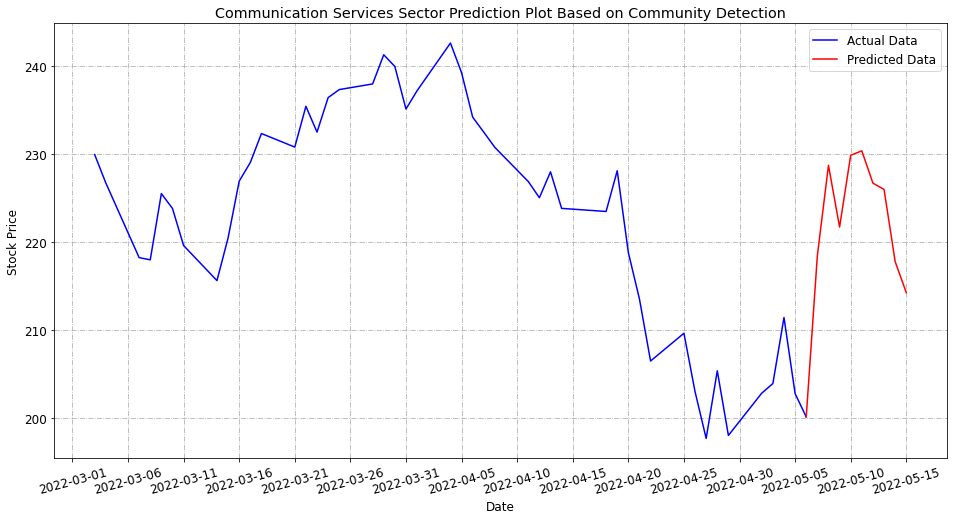

In [1213]:
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Communication Services Sector Prediction Plot Based on Community Detection")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.4.2 Yahoo Finance
- tickers = ['chtr','cmcsa','dis','fb','foxa','googl','nflx','t','tmus','vz']

In [1214]:
# import dataset of sector index and sentiment score
tickers = ['chtr','cmcsa','dis','fb','foxa','googl','nflx','t','tmus','vz']
sector = 'communicationservices'
df_commu_yahoo = import_dataset(tickers, sector)
df_commu_yahoo.replace(',','', regex=True, inplace=True)
df_commu_yahoo['close_price'] = df_commu_yahoo['close_price'].astype(float)
df_commu_yahoo

close_price  polarity_chtr  polarity_cmcsa  polarity_dis  \
date                                                                   
2022-03-03      229.920          0.396           0.297         0.075   
2022-03-07      218.220          0.491           0.372         0.022   
2022-03-08      217.970          0.500           0.020         0.114   
2022-03-09      225.490          1.000           0.600         0.252   
2022-03-10      223.800          0.851           0.120         0.113   
2022-03-11      219.590          0.762           0.600        -0.042   
2022-03-14      215.610          0.333           0.443         0.107   
2022-03-15      220.450          0.533           0.660         0.240   
2022-03-16      226.900          0.750           0.500         0.191   
2022-03-18      232.310          1.000           0.159         0.172   
2022-03-21      230.770          1.000           0.514         0.043   
2022-03-22      235.400          0.000           0.500         0.065   
2022-03-25      237.300          0.429           0.549         0.155   
2022-03-28      237.940          0.556           0.369         0.102   
2022-03-30      239.920          0.320           0.520         0.140   
2022-03-31      235.090          0.067           0.337         0.057   
2022-04-01      237.170          0.483           0.867         0.087   
2022-04-04      242.580          0.461          -0.009         0.054   
2022-04-05      239.220          0.241           0.045         0.126   
2022-04-06      234.170          0.667           0.355         0.127   
2022-04-07      232.460          0.472           0.048         0.048   
2022-04-11      226.860          0.641           0.167         0.084   
2022-04-12      225.020          0.733           0.489         0.126   
2022-04-14      223.810          0.867           0.143         0.057   
2022-04-18      223.460          0.667           0.406         0.102   
2022-04-19      228.080          0.325           0.160         0.074   
2022-04-20      218.800          0.825           0.164         0.060   
2022-04-21      213.520          0.125           0.000         0.020   
2022-04-25      209.630          0.333           0.299         0.128   
2022-04-26      203.000          0.880           0.399         0.040   
2022-04-28      205.370          0.440           0.107         0.082   
2022-05-03      203.920          0.561           0.537         0.053   
2022-05-04      211.420          0.593           0.595         0.065   
2022-05-05      202.780          0.750           0.424         0.041   
2022-05-06      200.130          0.833           0.139         0.149   

            polarity_fb  polarity_foxa  polarity_googl  polarity_nflx  \
date                                                                    
2022-03-03        0.080         -0.375           0.040          0.175   
2022-03-07        0.057         -0.500           0.093          0.065   
2022-03-08        0.063          0.701           0.253          0.073   
2022-03-09        0.098          0.000           0.133          0.255   
2022-03-10        0.078          0.387           0.142          0.128   
2022-03-11        0.079         -0.167           0.088          0.153   
2022-03-14        0.102          0.667           0.068          0.084   
2022-03-15        0.055          0.619           0.149          0.139   
2022-03-16        0.151          0.000           0.125          0.175   
2022-03-18        0.128          0.556           0.203          0.361   
2022-03-21        0.180         -1.000           0.098          0.160   
2022-03-22        0.139          0.000           0.107          0.171   
2022-03-25        0.204          0.554           0.004          0.173   
2022-03-28        0.112          0.000          -0.043         -0.029   
2022-03-30        0.107          0.500           0.093          0.042   
2022-03-31        0.096          0.241          -0.006          0.017   
2022-04-01        0.084          

In [1215]:
x = df_commu_yahoo.iloc[:, 1:11].values # close price
y = df_commu_yahoo.iloc[:, 0].values # 10 stocks' sentiment score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(28, 10) (7, 10)


In [1216]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1217]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[213.64974 213.89992 216.34674 225.98008 227.29692 217.86634 219.2279 ]
(7,)


In [1218]:
# Model Performance
mae_commu_yahoo = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_commu_yahoo = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_commu_yahoo = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_commu_yahoo = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_commu_yahoo = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_commu_yahoo)
print("Mean Squared Error:", mse_commu_yahoo)
print("Root Mean Squared Error:", rmse_commu_yahoo)
print("(R^2) Score:", r2_commu_yahoo)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_commu_yahoo, '%.') 

Mean Absolute Error: 13.918
Mean Squared Error: 227.698
Root Mean Squared Error: 15.0897
(R^2) Score: -0.5056
Train Score : 88.56% and Test Score : -50.56% using Random Tree Regressor.
Accuracy: 93.84 %.


In [1219]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_commu_yahoo.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06          213.650
2022-05-07          213.900
2022-05-08          216.347
2022-05-09          225.980
2022-05-10          227.297
2022-05-11          217.866
2022-05-12          219.228

In [1220]:
df_pred = pd.concat([df_commu_yahoo['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-03       229.920              NaN
2022-03-07       218.220              NaN
2022-03-08       217.970              NaN
2022-03-09       225.490              NaN
2022-03-10       223.800              NaN
2022-03-11       219.590              NaN
2022-03-14       215.610              NaN
2022-03-15       220.450              NaN
2022-03-16       226.900              NaN
2022-03-18       232.310              NaN
2022-03-21       230.770              NaN
2022-03-22       235.400              NaN
2022-03-25       237.300              NaN
2022-03-28       237.940              NaN
2022-03-30       239.920              NaN
2022-03-31       235.090              NaN
2022-04-01       237.170              NaN
2022-04-04       242.580              NaN
2022-04-05       239.220              NaN
2022-04-06       234.170              NaN
2022-04-07       232.460              NaN
2022-04-11       226.860              NaN
2022-04-12       225.020              NaN
2022-04-14       223.810              NaN
2022-04-18       223.460              NaN
2022-04-19       228.080              NaN
2022-04-20       218.800              NaN
2022-04-21       213.520              NaN
2022-04-25       209.630              NaN
2022-04-26       203.000              NaN
2022-04-28       205.370              NaN
2022-05-03       203.920              NaN
2022-05-04       211.420              NaN
2022-05-05       202.780              NaN
2022-05-06       200.130          200.130
2022-05-07           NaN          213.900
2022-05-08           NaN          216.347
2022-05-09           NaN          225.980
2022-05-10           NaN          227.297
2022-05-11           NaN          217.866
2022-05-12           NaN          219.228

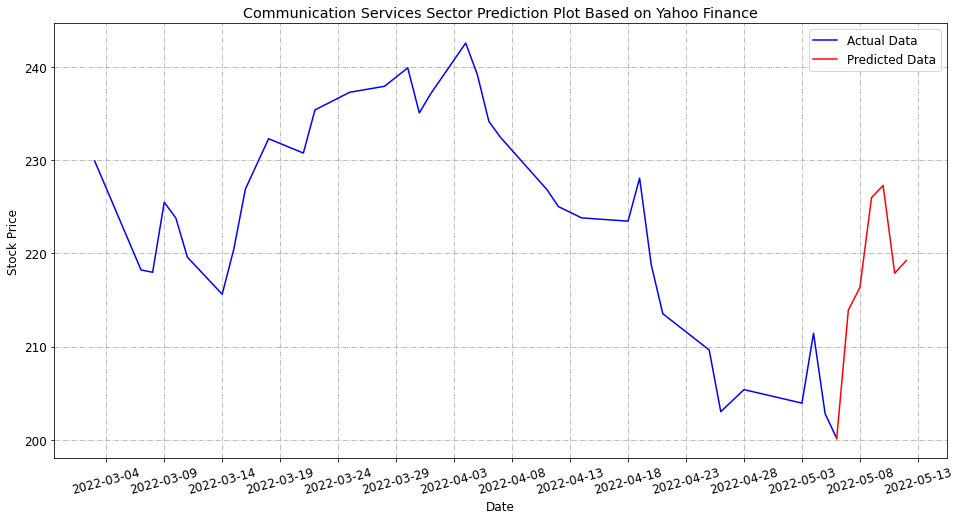

In [1221]:
# Visualization for Stock Price Prediction
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Communication Services Sector Prediction Plot Based on Yahoo Finance")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.4.3 Comparison of Model Performance between Yahoo Finance and Community Detection

In [1222]:
data_perf = {'MAE': [mae_commu_yahoo, 
                                    mae_commu_comm], 
             'MSE': [mse_commu_yahoo, 
                                    mse_commu_comm],
             'RMSE': [rmse_commu_yahoo, 
                                         rmse_commu_comm],
             'Accuracy (%)': [accuracy_commu_yahoo, 
                          accuracy_commu_comm]}

df_perf = pd.DataFrame(data_perf, index=['Yahoo Finance', 
                                         'Community Detection'])
df_perf.style.set_table_attributes("style='display:inline'").set_caption("Comparison of Model Performance between Yahoo Finance and Community Detectionn")
pd.set_option('display.precision', 3)
df_perf

MAE     MSE   RMSE  Accuracy (%)
Yahoo Finance       13.918 227.698 15.090        93.840
Community Detection  9.429 145.388 12.058        95.960

## 3.5 Information Technology

### 3.5.1 Community Detection
- com_1_2_1 = ['acn', 'adbe', 'bac', 'bmy', 'c', 'jpm', 'mdt', 'nke', 'pfe', 'pypl']

In [1126]:
# import dataset of sector index and sentiment score
tickers = com_1_2_1
sector = 'informationtechnology'
df_info_comm = import_dataset(tickers, sector)
df_info_comm.replace(',','', regex=True, inplace=True)
df_info_comm['close_price'] = df_info_comm['close_price'].astype(float)
df_info_comm

close_price  polarity_acn  polarity_adbe  polarity_bac  \
date                                                                 
2022-03-03     2671.600         0.330          0.503         0.180   
2022-03-04     2623.960         0.087          0.315         0.154   
2022-03-07     2526.920        -0.229          0.533         0.236   
2022-03-08     2516.120         0.500          0.437         0.229   
2022-03-09     2616.320         0.583          0.604         0.361   
2022-03-10     2570.380         0.867          0.332         0.231   
2022-03-11     2524.090         0.500          0.595         0.181   
2022-03-14     2476.220         0.305          0.577         0.225   
2022-03-15     2561.100         0.431          0.482         0.213   
2022-03-16     2646.170         0.569          0.375         0.213   
2022-03-17     2664.420         0.129          0.221         0.303   
2022-03-18     2722.710        -0.084          0.254         0.178   
2022-03-21     2717.900        -0.137          0.251         0.159   
2022-03-22     2756.550         0.467          0.033         0.231   
2022-03-23     2715.110         0.750          0.113         0.314   
2022-03-24     2788.630         0.568          0.205         0.140   
2022-03-25     2786.100         0.222          0.062         0.294   
2022-03-28     2820.350         0.551          0.171         0.383   
2022-03-29     2878.530         0.578          0.044         0.202   
2022-03-30     2839.310         0.500          0.300         0.221   
2022-03-31     2794.080        -0.343          0.276         0.173   
2022-04-01     2789.450         1.000          0.433         0.239   
2022-04-04     2842.790         0.198          0.147         0.211   
2022-04-05     2780.500         0.473          0.096         0.097   
2022-04-06     2709.720         0.665          0.536         0.213   
2022-04-07     2716.000         0.428          0.289         0.166   
2022-04-08     2677.040         0.322          0.283         0.119   
2022-04-11     2607.310         0.659          0.646         0.086   
2022-04-12     2598.100         0.400          0.033         0.130   
2022-04-13     2639.450         0.000          0.383         0.084   
2022-04-14     2574.880         0.671          0.109         0.178   
2022-04-18     2583.120         0.400          0.211         0.150   
2022-04-19     2630.640         0.592          0.413         0.221   
2022-04-20     2627.160         0.164          0.268         0.209   
2022-04-21     2581.780         0.570          0.284         0.105   
2022-04-22     2509.650         0.347          0.303         0.248   
2022-04-25     2545.760         0.493          0.544         0.154   
2022-04-26     2451.280         0.144          0.210         0.358   
2022-04-27     2484.580         0.542          0.300         0.125   
2022-04-28     2584.890         0.015          0.444         0.398   
2022-04-29     2478.000         0.722          0.220         0.230   
2022-05-02     2516.690         0.791          0.833         0.207   
2022-05-03     2521.230         0.518          0.269         0.169   
2022-05-04     2609.800         0.579          0.187         0.206   
2022-05-05     2481.200         0.857          0.375         0.363   
2022-05-06     2461.480         0.700          0.224         0.473   

            polarity_bmy  polarity_c  polarity_jpm  polarity_mdt  \
date                                                               
2022-03-03         0.312       0.376         0.048         0.077   
2022-03-04         0.351       0.297         0.159         0.177   
2022-03-07         0.308       0.425         0.160         0.300   
2022-03-08         0.271       0.402         0.209         0.439   
2022-03-09         0.524       0.529         0.065         0.010   
2022-03-10         0.363       0.300         0.084         0.375   
2022-03-11         0.108       0.342        -0.020         0.333   
2022-03-14         0.163       0.423   

In [1127]:
x = df_info_comm.iloc[:, 1:11].values # close price
y = df_info_comm.iloc[:, 0].values # 10 stocks' sentiment score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(36, 10) (10, 10)


In [1128]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1133]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[2594.51820933 2670.51082    2681.31668    2580.44742    2518.0624
 2648.8698     2631.91406    2657.338976   2630.77914    2584.77698   ]
(10,)


In [1134]:
# Model Performance

mae_info_comm = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_info_comm = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_info_comm = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_info_comm = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_info_comm = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_info_comm)
print("Mean Squared Error:", mse_info_comm)
print("Root Mean Squared Error:", rmse_info_comm)
print("(R^2) Score:", r2_info_comm)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_info_comm, '%.') 

Mean Absolute Error: 90.7028
Mean Squared Error: 11149.4131
Root Mean Squared Error: 105.5908
(R^2) Score: -0.6616
Train Score : 86.99% and Test Score : -66.16% using Random Tree Regressor.
Accuracy: 96.66 %.


In [1135]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_info_comm.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06         2594.518
2022-05-07         2670.511
2022-05-08         2681.317
2022-05-09         2580.447
2022-05-10         2518.062
2022-05-11         2648.870
2022-05-12         2631.914
2022-05-13         2657.339
2022-05-14         2630.779
2022-05-15         2584.777

In [1136]:
df_pred = pd.concat([df_info_comm['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-03      2671.600              NaN
2022-03-04      2623.960              NaN
2022-03-07      2526.920              NaN
2022-03-08      2516.120              NaN
2022-03-09      2616.320              NaN
2022-03-10      2570.380              NaN
2022-03-11      2524.090              NaN
2022-03-14      2476.220              NaN
2022-03-15      2561.100              NaN
2022-03-16      2646.170              NaN
2022-03-17      2664.420              NaN
2022-03-18      2722.710              NaN
2022-03-21      2717.900              NaN
2022-03-22      2756.550              NaN
2022-03-23      2715.110              NaN
2022-03-24      2788.630              NaN
2022-03-25      2786.100              NaN
2022-03-28      2820.350              NaN
2022-03-29      2878.530              NaN
2022-03-30      2839.310              NaN
2022-03-31      2794.080              NaN
2022-04-01      2789.450              NaN
2022-04-04      2842.790              NaN
2022-04-05      2780.500              NaN
2022-04-06      2709.720              NaN
2022-04-07      2716.000              NaN
2022-04-08      2677.040              NaN
2022-04-11      2607.310              NaN
2022-04-12      2598.100              NaN
2022-04-13      2639.450              NaN
2022-04-14      2574.880              NaN
2022-04-18      2583.120              NaN
2022-04-19      2630.640              NaN
2022-04-20      2627.160              NaN
2022-04-21      2581.780              NaN
2022-04-22      2509.650              NaN
2022-04-25      2545.760              NaN
2022-04-26      2451.280              NaN
2022-04-27      2484.580              NaN
2022-04-28      2584.890              NaN
2022-04-29      2478.000              NaN
2022-05-02      2516.690              NaN
2022-05-03      2521.230              NaN
2022-05-04      2609.800              NaN
2022-05-05      2481.200              NaN
2022-05-06      2461.480         2461.480
2022-05-07           NaN         2670.511
2022-05-08           NaN         2681.317
2022-05-09           NaN         2580.447
2022-05-10           NaN         2518.062
2022-05-11           NaN         2648.870
2022-05-12           NaN         2631.914
2022-05-13           NaN         2657.339
2022-05-14           NaN         2630.779
2022-05-15           NaN         2584.777

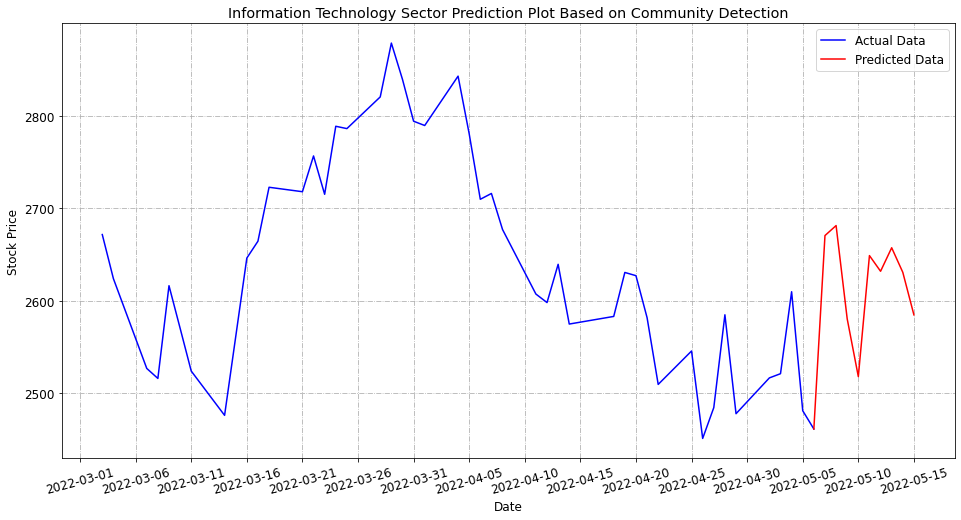

In [1137]:
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Information Technology Sector Prediction Plot Based on Community Detection")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.5.2 Yahoo Finance
- tickers = ['aapl','acn','adbe','csco','ibm','intc','ma','msft','orcl','pypl']

In [1138]:
# import dataset of sector index and sentiment score
tickers = ['aapl','acn','adbe','csco','ibm','intc','ma','msft','orcl','pypl']
sector = 'informationtechnology'
df_info_yahoo = import_dataset(tickers, sector)
df_info_yahoo.replace(',','', regex=True, inplace=True)
df_info_yahoo['close_price'] = df_info_yahoo['close_price'].astype(float)
df_info_yahoo

close_price  polarity_aapl  polarity_acn  polarity_adbe  \
date                                                                  
2022-03-02     2705.230          0.101         0.500          0.320   
2022-03-03     2671.600          0.077         0.330          0.503   
2022-03-04     2623.960          0.137         0.087          0.315   
2022-03-07     2526.920          0.077        -0.229          0.533   
2022-03-08     2516.120          0.163         0.500          0.437   
2022-03-09     2616.320          0.068         0.583          0.604   
2022-03-10     2570.380          0.084         0.867          0.332   
2022-03-11     2524.090          0.053         0.500          0.595   
2022-03-14     2476.220          0.117         0.305          0.577   
2022-03-15     2561.100          0.114         0.431          0.482   
2022-03-16     2646.170          0.044         0.569          0.375   
2022-03-17     2664.420          0.097         0.129          0.221   
2022-03-18     2722.710          0.185        -0.084          0.254   
2022-03-21     2717.900          0.123        -0.137          0.251   
2022-03-22     2756.550          0.128         0.467          0.033   
2022-03-23     2715.110          0.108         0.750          0.113   
2022-03-24     2788.630          0.067         0.568          0.205   
2022-03-25     2786.100          0.059         0.222          0.062   
2022-03-28     2820.350          0.085         0.551          0.171   
2022-03-29     2878.530          0.059         0.578          0.044   
2022-03-30     2839.310          0.095         0.500          0.300   
2022-03-31     2794.080          0.068        -0.343          0.276   
2022-04-01     2789.450          0.073         1.000          0.433   
2022-04-04     2842.790          0.141         0.198          0.147   
2022-04-05     2780.500          0.099         0.473          0.096   
2022-04-06     2709.720          0.087         0.665          0.536   
2022-04-07     2716.000          0.119         0.428          0.289   
2022-04-08     2677.040          0.098         0.322          0.283   
2022-04-11     2607.310          0.107         0.659          0.646   
2022-04-12     2598.100          0.076         0.400          0.033   
2022-04-13     2639.450          0.096         0.000          0.383   
2022-04-14     2574.880          0.115         0.671          0.109   
2022-04-18     2583.120          0.115         0.400          0.211   
2022-04-19     2630.640          0.094         0.592          0.413   
2022-04-20     2627.160          0.088         0.164          0.268   
2022-04-21     2581.780          0.085         0.570          0.284   
2022-04-22     2509.650          0.124         0.347          0.303   
2022-04-25     2545.760          0.123         0.493          0.544   
2022-04-26     2451.280          0.116         0.144          0.210   
2022-04-27     2484.580          0.121         0.542          0.300   
2022-04-28     2584.890          0.018         0.015          0.444   
2022-04-29     2478.000          0.077         0.722          0.220   
2022-05-02     2516.690          0.047         0.791          0.833   
2022-05-03     2521.230          0.057         0.518          0.269   
2022-05-04     2609.800          0.083         0.579          0.187   
2022-05-05     2481.200          0.079         0.857          0.375   
2022-05-06     2461.480          0.083         0.700          0.224   

            polarity_csco  polarity_ibm  polarity_intc  polarity_ma  \
date                                                                  
2022-03-02          0.148         0.251          0.168        0.323   
2022-03-03          0.491         0.477          0.220        0.311   
2022-03-04          0.448         0.186          0.316        0.327   
2022-03-07          0.092         0.033          0.186        0.254   
2022-03-08          0.536         0.607          0.264        0.236   
2022-03-09          0.211         0

In [1139]:
x = df_info_yahoo.iloc[:, 1:11].values # close price
y = df_info_yahoo.iloc[:, 0].values # 10 stocks' sentiment score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
print(x_train.shape, x_test.shape)

(37, 10) (10, 10)


In [1145]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [1146]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=42, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_depth=10, 
                              bootstrap=True)
model.fit(x_train, y_train)
predict_test = model.predict(x_test)
print(predict_test)
print(predict_test.shape)

[2549.78033333 2694.60769    2592.0762     2574.566275   2683.15053333
 2694.71559333 2545.46702    2692.85883    2574.054284   2648.43051   ]
(10,)


In [1147]:
# Model Performance
mae_info_yahoo = round(metrics.mean_absolute_error(y_test, predict_test), 4)
mse_info_yahoo = round(metrics.mean_squared_error(y_test, predict_test), 4)
rmse_info_yahoo = round(np.sqrt(metrics.mean_squared_error(y_test, predict_test)), 4)
r2_info_yahoo = round(metrics.r2_score(y_test, predict_test), 4)
                       
errors = abs(predict_test - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
accuracy_info_yahoo = round(accuracy, 2)
                      
print("Mean Absolute Error:", mae_info_yahoo)
print("Mean Squared Error:", mse_info_yahoo)
print("Root Mean Squared Error:", rmse_info_yahoo)
print("(R^2) Score:", r2_info_yahoo)
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
print('Accuracy:', accuracy_info_yahoo, '%.') 

Mean Absolute Error: 75.9225
Mean Squared Error: 9395.0834
Root Mean Squared Error: 96.9282
(R^2) Score: -0.0274
Train Score : 87.90% and Test Score : -2.74% using Random Tree Regressor.
Accuracy: 97.17 %.


In [1148]:
predictions = pd.DataFrame({"predicted_price": predict_test}, 
                           index=pd.date_range(start=df_info_yahoo.index[-1], 
                                               periods=len(predict_test), freq="D"))
predictions.index.name = 'date'
predictions

predicted_price
date                       
2022-05-06         2549.780
2022-05-07         2694.608
2022-05-08         2592.076
2022-05-09         2574.566
2022-05-10         2683.151
2022-05-11         2694.716
2022-05-12         2545.467
2022-05-13         2692.859
2022-05-14         2574.054
2022-05-15         2648.431

In [1149]:
df_pred = pd.concat([df_info_yahoo['close_price'], predictions[1:]])
df_pred.index = pd.to_datetime(df_pred.index)
df_pred.rename(columns={0:'actual_price'}, inplace=True)
df_pred['predicted_price']['2022-05-06'] = df_pred['actual_price']['2022-05-06']
df_pred

actual_price  predicted_price
date                                     
2022-03-02      2705.230              NaN
2022-03-03      2671.600              NaN
2022-03-04      2623.960              NaN
2022-03-07      2526.920              NaN
2022-03-08      2516.120              NaN
2022-03-09      2616.320              NaN
2022-03-10      2570.380              NaN
2022-03-11      2524.090              NaN
2022-03-14      2476.220              NaN
2022-03-15      2561.100              NaN
2022-03-16      2646.170              NaN
2022-03-17      2664.420              NaN
2022-03-18      2722.710              NaN
2022-03-21      2717.900              NaN
2022-03-22      2756.550              NaN
2022-03-23      2715.110              NaN
2022-03-24      2788.630              NaN
2022-03-25      2786.100              NaN
2022-03-28      2820.350              NaN
2022-03-29      2878.530              NaN
2022-03-30      2839.310              NaN
2022-03-31      2794.080              NaN
2022-04-01      2789.450              NaN
2022-04-04      2842.790              NaN
2022-04-05      2780.500              NaN
2022-04-06      2709.720              NaN
2022-04-07      2716.000              NaN
2022-04-08      2677.040              NaN
2022-04-11      2607.310              NaN
2022-04-12      2598.100              NaN
2022-04-13      2639.450              NaN
2022-04-14      2574.880              NaN
2022-04-18      2583.120              NaN
2022-04-19      2630.640              NaN
2022-04-20      2627.160              NaN
2022-04-21      2581.780              NaN
2022-04-22      2509.650              NaN
2022-04-25      2545.760              NaN
2022-04-26      2451.280              NaN
2022-04-27      2484.580              NaN
2022-04-28      2584.890              NaN
2022-04-29      2478.000              NaN
2022-05-02      2516.690              NaN
2022-05-03      2521.230              NaN
2022-05-04      2609.800              NaN
2022-05-05      2481.200              NaN
2022-05-06      2461.480         2461.480
2022-05-07           NaN         2694.608
2022-05-08           NaN         2592.076
2022-05-09           NaN         2574.566
2022-05-10           NaN         2683.151
2022-05-11           NaN         2694.716
2022-05-12           NaN         2545.467
2022-05-13           NaN         2692.859
2022-05-14           NaN         2574.054
2022-05-15           NaN         2648.431

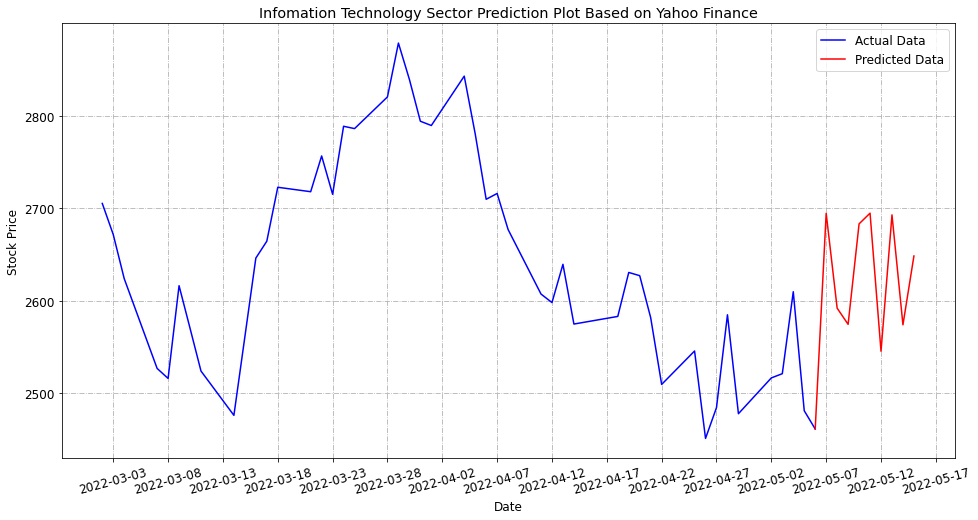

In [1150]:
# Visualization for Stock Price Prediction
plt.figure(figsize=(16, 8))
plt.plot(df_pred.actual_price, color='blue', label='Actual Data')
plt.plot(df_pred.predicted_price, color='red', label='Predicted Data')

plt.setp(plt.gca().get_xticklabels(), rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=15)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title("Infomation Technology Sector Prediction Plot Based on Yahoo Finance")
plt.legend()
plt.grid(linestyle='-.')
plt.rcParams.update({'font.size': 12})
plt.show()

### 3.5.3 Comparison of Model Performance between Yahoo Finance and Community Detection

In [1151]:
data_perf = {'MAE': [mae_info_yahoo, 
                                    mae_info_comm], 
             'MSE': [mse_info_yahoo, 
                                    mse_info_comm],
             'RMSE': [rmse_info_yahoo, 
                                         rmse_info_comm],
             'Accuracy (%)': [accuracy_info_yahoo, 
                          accuracy_info_comm]}

df_perf = pd.DataFrame(data_perf, index=['Yahoo Finance', 
                                         'Community Detection'])
df_perf.style.set_table_attributes("style='display:inline'").set_caption("Comparison of Model Performance between Yahoo Finance and Community Detectionn")
pd.set_option('display.precision', 3)
df_perf

MAE       MSE    RMSE  Accuracy (%)
Yahoo Finance       75.922  9395.083  96.928        97.170
Community Detection 90.703 11149.413 105.591        96.660